<a href="https://colab.research.google.com/github/drshahizan/Python_EDA/blob/main/lab/eda/hpdp/lab_muhaimin/eda_of_7_million_company_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis of 7+ million company dataset

## Objective

* What can we learn about business names?
* How can we use these insights?

## Imports

In [89]:
pip install mapclassify

In [17]:
pip install geotext

In [18]:
pip install -U kaleido

In [19]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geotext
import collections
import string, sys, os, re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image
from functools import reduce
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [90]:
import gc
import glob
import os
import mapclassify

In [21]:
warnings.filterwarnings('ignore')

## Helper functions and classes

In [22]:
class DfOverview:
    """
        Give an overview for a given data frame,
        like null persentage for each columns,
        unique value percentage for each columns and more
    """

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def missing_value(self) -> None:
        nullSum = self.df.isna().sum()
        return [col for col in nullSum]

    def percentage(self, list):
        return [str(round(((value / self.df.shape[0]) * 100), 2)) + '%' for value in list]

    def getOverview(self) -> None:

        _columns = [column for column in self.df]
        _count = self.df.count().values
        _unique = [self.df[column].value_counts().shape[0] for column in self.df]
        _missing_values = self.missing_value()

        columns = [
            'Column',
            'count',
            'missing_value_count',
            'Missing_value_percentage',
            'unique_value_count',
            'unique_value_percentage',
            'dtype']
        data = zip(
            _columns,
            _count,
            _missing_values,
            self.percentage(_missing_values),
            _unique,
            self.percentage(_unique),
            self.df.dtypes
        )
        new_df = pd.DataFrame(data=data, columns=columns)
        return new_df

In [23]:
def show_cols_mixed_dtypes(df):
    mixed_dtypes = {'Column': [], 'Data type': []}
    for col in df.columns:
        dtype = pd.api.types.infer_dtype(df[col])
        if dtype.startswith("mixed"):
            mixed_dtypes['Column'].append(col)
            mixed_dtypes['Data type'].append(dtype)
    if len(mixed_dtypes['Column']) == 0:
        print('None of the columns contain mixed types.')
    else:
        print(pd.DataFrame(mixed_dtypes))

In [24]:
def percent_missing_values(df):

    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print("The dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")

In [25]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * mis_val / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending and remove columns with no missing values
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,0] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    if mis_val_table_ren_columns.shape[0] == 0:
        return

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [26]:
def convert_to_string(df, columns):
    for col in columns:
        df[col] = df[col].astype("string")

In [27]:
def drop_duplicates(df):
    old = df.shape[0]
    df.drop_duplicates(inplace=True)
    new = df.shape[0]
    count = old - new
    if (count == 0):
        print("No duplicate rows were found.")
    else:
        print(f"{count} duplicate rows were found and removed.")

def plot_dist(df:pd.DataFrame, column:str, color:str='cornflowerblue')->None:
    sns.displot(data=df, x=column, color=color,  kde=False, height=6, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plotly_plot_bar(df, x, y, title=None, width=800, color=['cornflowerblue']):
    if title == None:
        title=f'Distribution of {x}'
    fig = px.bar(df, x=x, y=y, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

def plotly_plot_pie(df, column, title=None, width=800, limit=None):
    a = pd.DataFrame({'count': df.groupby([column]).size()}).reset_index()
    a = a.sort_values("count", ascending=False)
    if limit:
        a.loc[a['count'] < limit, column] = f'Other {column}s'
    if title == None:
        title=f'Distribution of {column}'
    fig = px.pie(a, values='count', names=column, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

## Data Reading

In [28]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/dataset2.csv"

chunk_size = 500000
num = 1
for chunk in pd.read_csv(path,chunksize = chunk_size) :
    chunk.to_csv('chunk' + str(num) + '.csv',index = False )
    gc.collect()
    num += 1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
df = pd.read_csv('chunk2.csv')
df

Unnamed: 0                                               name  \
0          4819089                           stella nova technologies   
1          4539011                                new world solutions   
2          2853171                                           happydna   
3          3206198                                    greater than ab   
4          4102864                atma - an accelerator for education   
...            ...                                                ...   
499995     5089757                                    secan aerospace   
499996     4370234                                the jacques company   
499997     3350136  enigma - adventure tour operator / travel coll...   
499998      440585                                  furuno cyprus ltd   
499999     5341998                               amasya üniversitesi   

                         domain  year founded  \
0                    sntinc.com        2001.0   
1       new-world-solutions.com        2002.0   
2                   happydna.in        2016.0   
3                greaterthan.eu        2004.0   
4                   atma.org.in        2007.0   
...                         ...           ...   
499995                      NaN           NaN   
499996          jerrykalman.com           NaN   
499997           enigmaperu.com        2002.0   
499998            furuno.com.cy        2012.0   
499999                      NaN           NaN   

                                   industry size range  \
0       information technology and services    11 - 50   
1                           defense & space    11 - 50   
2              health, wellness and fitness   51 - 200   
3       information technology and services   51 - 200   
4        non-profit organization management   51 - 200   
...                                     ...        ...   
499995                 aviation & aerospace    11 - 50   
499996                          real estate    11 - 50   
499997            leisure, travel & tourism    11 - 50   
499998                             maritime    11 - 50   
499999                     higher education    11 - 50   

                                          locality        country  \
0       wake forest, north carolina, united states  united states   
1                 herndon, virginia, united states  united states   
2                     calcutta, west bengal, india          india   
3                stockholm, stockholms lan, sweden         sweden   
4                       bombay, maharashtra, india          india   
...                                            ...            ...   
499995                                         NaN            NaN   
499996                                         NaN            NaN   
499997                          cusco, cusco, peru           peru   
499998                                         NaN         cyprus   
499999                                         NaN            NaN   

                                             linkedin url  \
0           linkedin.com/company/stella-nova-technologies   
1                linkedin.com/company/new-world-solutions   
2                           linkedin.com/company/happydna   
3                       linkedin.com/company/greater-than   
4                     linkedin.com/company/atma-education   
...                                                   ...   
499995    linkedin.com/company/linkedin.comsecanaerospace   
499996           linkedin.com/company/the-jacques-company   
499997  linkedin.com/company/enigma-adventure-tour-ope...   
499998             linkedin.com/company/furuno-cyprus-ltd   
499999          linkedin.com/company/amasya-üniversitesi   

        current employee estimate  total employee estimate  
0                              18                       49  
1                              18                       33  
2                              18                       19  
3                              18      

## General Statistics

In [30]:
# number of elements(cells) in the df
df.size

5500000

In [31]:
# rows and columns in the df
df.shape

(500000, 11)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 500000 non-null  int64  
 1   name                       499999 non-null  object 
 2   domain                     442105 non-null  object 
 3   year founded               329010 non-null  float64
 4   industry                   499956 non-null  object 
 5   size range                 500000 non-null  object 
 6   locality                   381744 non-null  object 
 7   country                    392489 non-null  object 
 8   linkedin url               500000 non-null  object 
 9   current employee estimate  500000 non-null  int64  
 10  total employee estimate    500000 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 42.0+ MB


In [33]:
df_overview = DfOverview(df)
df_overview.getOverview()

Column   count  missing_value_count  \
0                  Unnamed: 0  500000                    0   
1                        name  499999                    1   
2                      domain  442105                57895   
3                year founded  329010               170990   
4                    industry  499956                   44   
5                  size range  500000                    0   
6                    locality  381744               118256   
7                     country  392489               107511   
8                linkedin url  500000                    0   
9   current employee estimate  500000                    0   
10    total employee estimate  500000                    0   

   Missing_value_percentage  unique_value_count unique_value_percentage  \
0                      0.0%              500000                  100.0%   
1                      0.0%              498043                  99.61%   
2                    11.58%              441694                  88.34%   
3                     34.2%                 218                   0.04%   
4                     0.01%                 148                   0.03%   
5                      0.0%                   2                    0.0%   
6                    23.65%               31635                   6.33%   
7                     21.5%                 221                   0.04%   
8                      0.0%              500000                  100.0%   
9                      0.0%                  11                    0.0%   
10                     0.0%                 543                   0.11%   

      dtype  
0     int64  
1    object  
2    object  
3   float64  
4    object  
5    object  
6    object  
7    object  
8    object  
9     int64  
10    int64

Here we can see detailed informations of the columns including the amount missing and unique values.

## Dropping unnecessary Columns

The column 'Unamed: 0' most of the times represents the index when we save our dataframe to csv along with our index. In this is the case, since each index is unique and not actually related to each row, removing it is advisable. Let us check its uniqueness.

In [34]:
# comparing the number of unique values of 'Unnamed: 0' and the number of rows
len(df['Unnamed: 0'].unique()) == df.shape[0]

True

Since my assumption is correct, I will remove the column.

In [35]:
df.drop(columns=['Unnamed: 0'], inplace=True)

## Missing Values

In [36]:
percent_missing_values(df)

The dataset contains 9.09 % missing values.


In [37]:
missing_values_table(df)

Your selected dataframe has 10 columns.
There are 6 columns that have missing values.


Missing Values  % of Total Values    Dtype
year founded          170990              34.20  float64
locality              118256              23.65   object
country               107511              21.50   object
domain                 57895              11.58   object
industry                  44               0.01   object
name                       1               0.00   object

From the missing table we can see that there are 6 columns with missing values. But name and industry are very necessary. So we will remove rows with null values in these columns.

In [38]:
df.drop(df.index[df.name.isna()], inplace=True)
df.drop(df.index[df.industry.isna()], inplace=True)

In [39]:
missing_values_table(df)

Your selected dataframe has 10 columns.
There are 4 columns that have missing values.


Missing Values  % of Total Values    Dtype
year founded          170946              34.19  float64
locality              118224              23.65   object
country               107480              21.50   object
domain                 57883              11.58   object

## Data Types

Let's check if there are columns with mixed data types.

In [40]:
show_cols_mixed_dtypes(df)

None of the columns contain mixed types.


In [41]:
df.dtypes

name                          object
domain                        object
year founded                 float64
industry                      object
size range                    object
locality                      object
country                       object
linkedin url                  object
current employee estimate      int64
total employee estimate        int64
dtype: object

In [42]:
df.head()

name                   domain  year founded  \
0             stella nova technologies               sntinc.com        2001.0   
1                  new world solutions  new-world-solutions.com        2002.0   
2                             happydna              happydna.in        2016.0   
3                      greater than ab           greaterthan.eu        2004.0   
4  atma - an accelerator for education              atma.org.in        2007.0   

                              industry size range  \
0  information technology and services    11 - 50   
1                      defense & space    11 - 50   
2         health, wellness and fitness   51 - 200   
3  information technology and services   51 - 200   
4   non-profit organization management   51 - 200   

                                     locality        country  \
0  wake forest, north carolina, united states  united states   
1            herndon, virginia, united states  united states   
2                calcutta, west bengal, india          india   
3           stockholm, stockholms lan, sweden         sweden   
4                  bombay, maharashtra, india          india   

                                    linkedin url  current employee estimate  \
0  linkedin.com/company/stella-nova-technologies                         18   
1       linkedin.com/company/new-world-solutions                         18   
2                  linkedin.com/company/happydna                         18   
3              linkedin.com/company/greater-than                         18   
4            linkedin.com/company/atma-education                         18   

   total employee estimate  
0                       49  
1                       33  
2                       19  
3                       28  
4                       91

As we can see from above 'name', 'domain', 'industry', 'size range', 'locality', 'country' and 'linkedin url' hold string values. In addition to this we also know that 'year founded' should hold integer values. Therefore, we will convert these columns to their respective correct data types.

In [43]:
# get the columns with object data type
string_columns = df.select_dtypes(include='object').columns.tolist()
string_columns

['name',
 'domain',
 'industry',
 'size range',
 'locality',
 'country',
 'linkedin url']

In [44]:
convert_to_string(df, string_columns)

In order to convert 'year founded', we have to replace NaN values with 0 so that pandas will not raise an error saying "Cannot convert non-finite values (NA or inf) to integer".

In [45]:
df['year founded'].fillna(0, inplace=True)
df['year founded'] = df['year founded'].astype('int64')

In [46]:
df.dtypes

name                         string
domain                       string
year founded                  int64
industry                     string
size range                   string
locality                     string
country                      string
linkedin url                 string
current employee estimate     int64
total employee estimate       int64
dtype: object

In [47]:
df.head()

name                   domain  year founded  \
0             stella nova technologies               sntinc.com          2001   
1                  new world solutions  new-world-solutions.com          2002   
2                             happydna              happydna.in          2016   
3                      greater than ab           greaterthan.eu          2004   
4  atma - an accelerator for education              atma.org.in          2007   

                              industry size range  \
0  information technology and services    11 - 50   
1                      defense & space    11 - 50   
2         health, wellness and fitness   51 - 200   
3  information technology and services   51 - 200   
4   non-profit organization management   51 - 200   

                                     locality        country  \
0  wake forest, north carolina, united states  united states   
1            herndon, virginia, united states  united states   
2                calcutta, west bengal, india          india   
3           stockholm, stockholms lan, sweden         sweden   
4                  bombay, maharashtra, india          india   

                                    linkedin url  current employee estimate  \
0  linkedin.com/company/stella-nova-technologies                         18   
1       linkedin.com/company/new-world-solutions                         18   
2                  linkedin.com/company/happydna                         18   
3              linkedin.com/company/greater-than                         18   
4            linkedin.com/company/atma-education                         18   

   total employee estimate  
0                       49  
1                       33  
2                       19  
3                       28  
4                       91

Now every data type looks good.

## Duplicates

In [48]:
# search for duplicate rows and drop them
drop_duplicates(df)

No duplicate rows were found.


Since name is the feature that uniquely identifies each record(company)record, there should be no duplicates. Let's check that.

In [49]:
df.duplicated(subset=['name']).all()

False

We are safe. No two rows in our dataset contain the same name value.

## Univariate Analysis

Here we will analyze each variable. Let us start by checking the statistics of numeric variables.

In [50]:
df.describe().transpose()

count         mean         std  min   25%  \
year founded               499955.0  1312.343193  946.174852  0.0   0.0   
current employee estimate  499955.0    11.621772    2.914286  8.0   9.0   
total employee estimate    499955.0    27.972234   26.537031  8.0  16.0   

                              50%     75%     max  
year founded               1988.0  2006.0  2018.0  
current employee estimate    11.0    14.0    18.0  
total employee estimate      22.0    32.0  3033.0

Here we can see some wierd results.
* the maximum value for 'year founded' is 2103.
* the minimum value for 'current employee estimate' is 0.

We will check these in detail when we analyze each column.

### Name

In [51]:
# unique value counts
counts_df = df['name'].value_counts().rename_axis('name').reset_index(name='count')
counts_df

name  count
0                           evolve      5
1                           canopy      4
2                              evo      4
3                          integra      4
4                     freiberufler      4
...                            ...    ...
497994        excel industries llc      1
497995                    mobitech      1
497996             sparbanken finn      1
497997  gatehouse capital k.s.c.c.      1
497998        amasya üniversitesi      1

[497999 rows x 2 columns]

Even though pandas.DataFrame.duplicated haven't identified any duplicated names, we have discovered there are some using value_counts. Let's investigate these names.

In [52]:
repeated_names = counts_df[counts_df['count'] > 1].name.to_list()

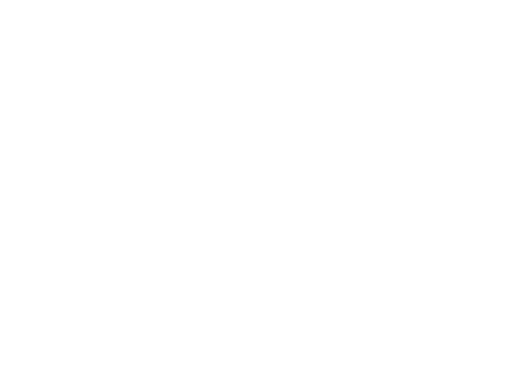

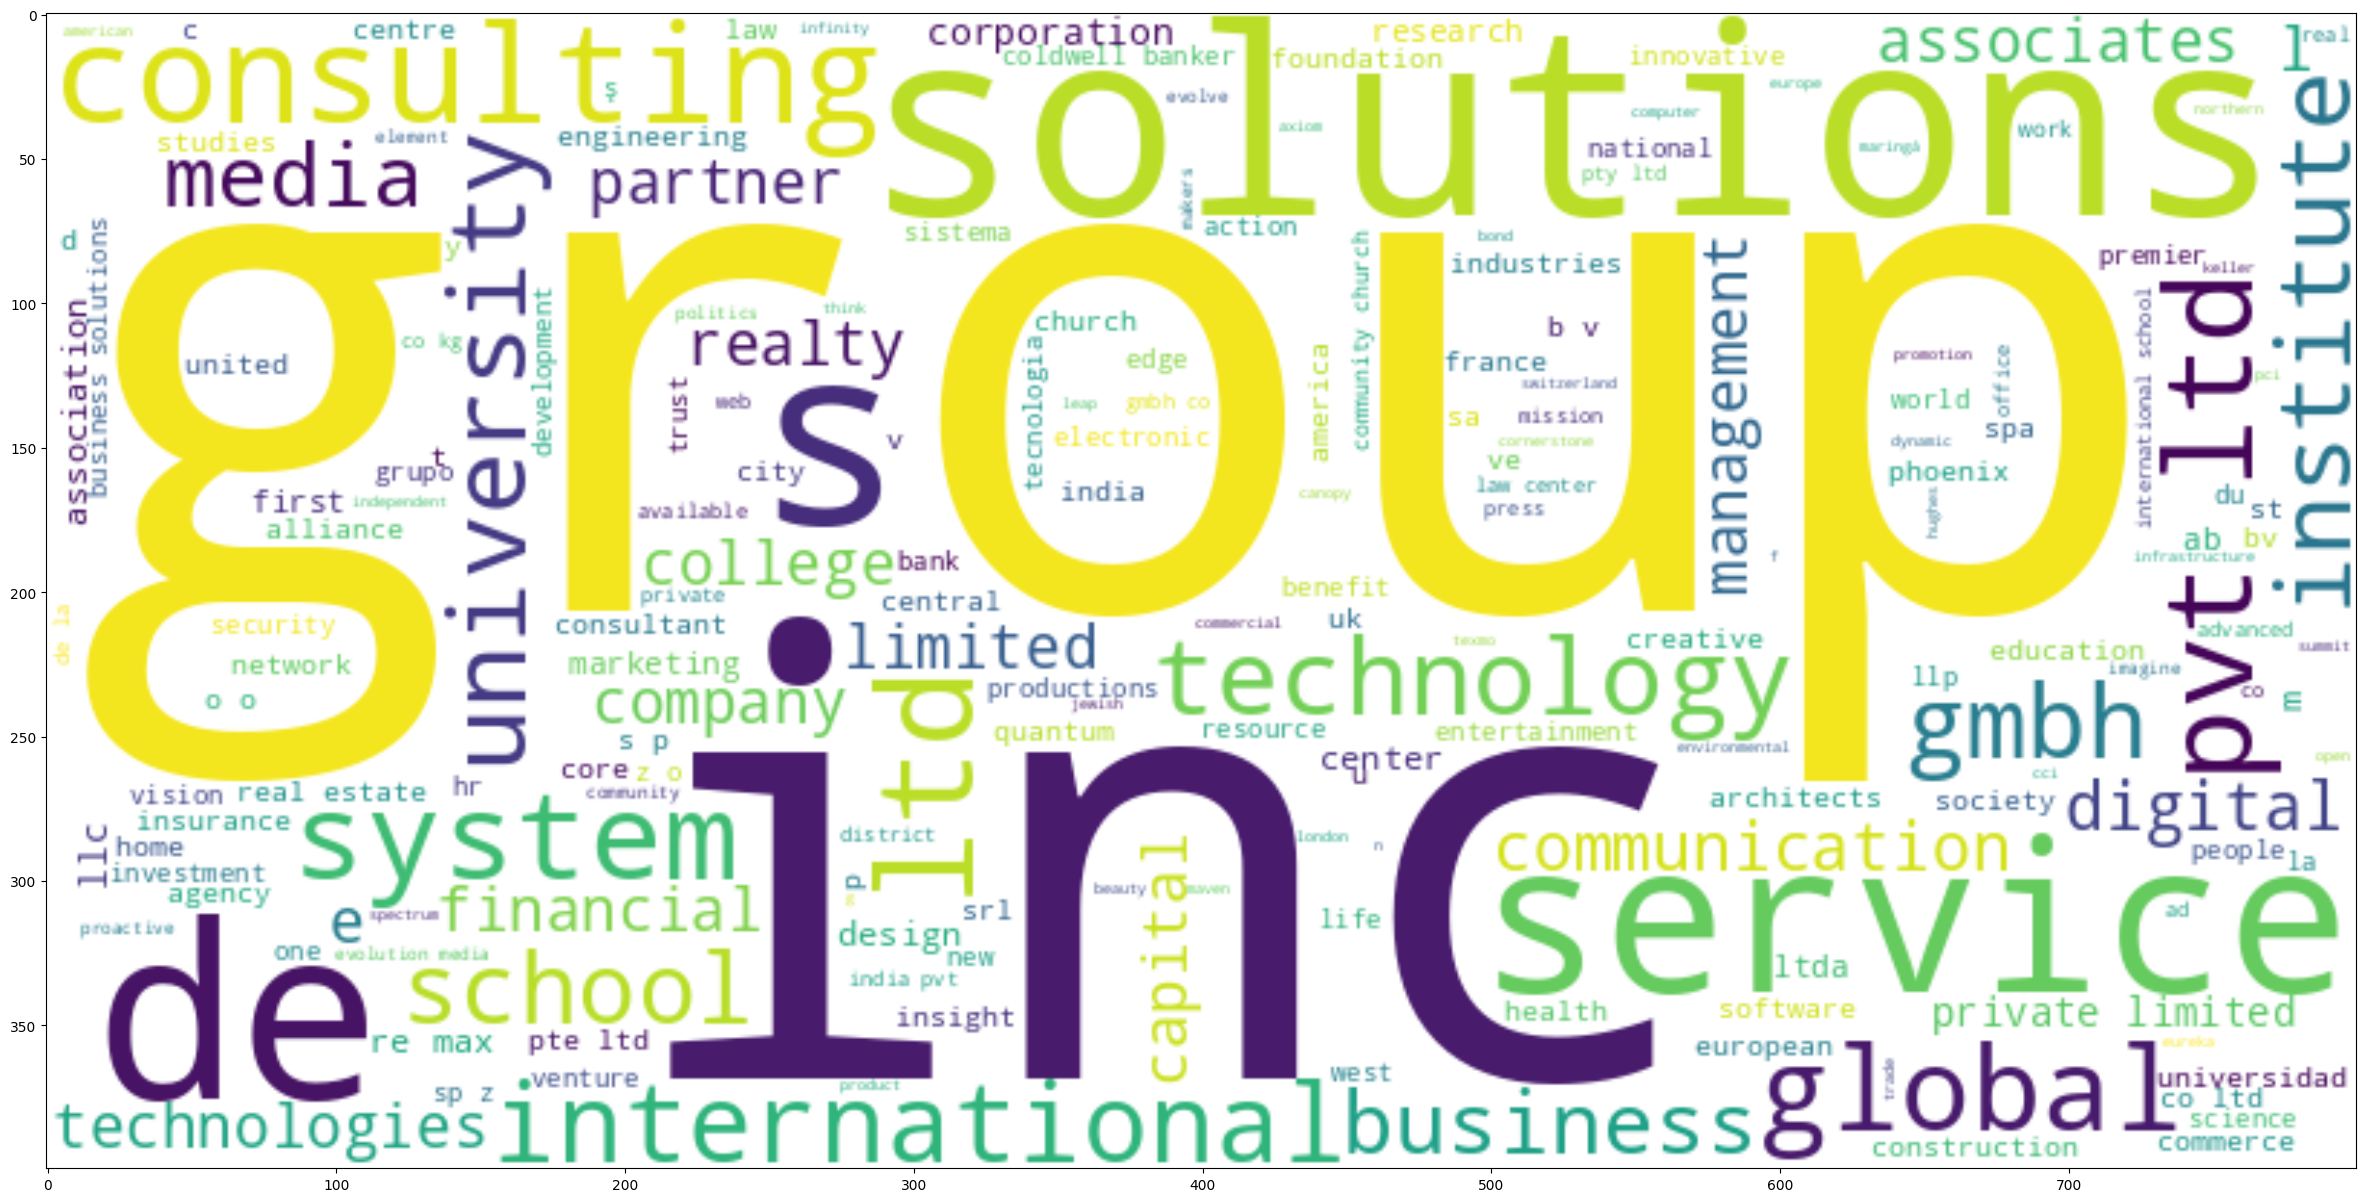

In [53]:
text = " ".join(name for name in df[df.name.isin(repeated_names)].name)

# generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

# display the word cloud
plt.axis("off")
plt.figure(figsize=(30,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

The most frequent words in these repeating company names are common words like group, inc, consulting and solution. Having companines with the exact same name in our dataset will conflict with our objective of extracting insights from business names since the values in the other columns differ. So I will remove the companies with their names repeated.

In [54]:
df = df[~df.name.isin(repeated_names)]

Let us examine if there are names containing different kinds of characters other than the english alphabets and space.

In [55]:
# filtering names with a character that is not an english alphabet or space
regexp = re.compile(r'[^a-zA-Z\s]')
df[df.name.apply(lambda x: regexp.search(x)).astype('bool')].name

4                       atma - an accelerator for education
5                                 lifegen technologies, llc
10                                   shore bancshares, inc.
16                                              diagnóstiqa
20                                        staffinders, inc.
                                ...                        
499988                                          somosur s.l
499992                               century 21 concept 100
499993           hargrove, smelley, strickland, and langley
499997    enigma - adventure tour operator / travel coll...
499999                                 amasya üniversitesi
Name: name, Length: 166217, dtype: string

In [56]:
# filtering names with non-aschii characters, here I considered on the standard aschii characters
regexp = re.compile(r'[^\x00-\x7f]')
df[df.name.apply(lambda x: regexp.search(x)).astype('bool')].name

16                                            diagnóstiqa
26                           suplicy cafés especiais ltda
27                          centro de valorização da vida
56                     racoon rengøring & ejendomsservice
61              asociación de industriales de antofagasta
                               ...                       
499915                     colegio de psicólogos de chile
499958               especialidades químicas quimidal,c.a
499981                             benu magyarország zrt.
499987    strategiya - soluções em comércio exterior e ti
499999                               amasya üniversitesi
Name: name, Length: 23086, dtype: string

In [57]:
# filtering names with digits
regexp = re.compile(r'[0-9]')
df[df.name.apply(lambda x: regexp.search(x)).astype('bool')].name

52               3d product development pvt. ltd
63        tiara yachts - a division of s2 yachts
141                                  5q partners
358                            iso/iec jtc 1/sc7
429                                         net7
                           ...                  
499765                                   studio3
499766      holiday inn express bogota parque 93
499787                                83zero ltd
499794                                    city42
499992                    century 21 concept 100
Name: name, Length: 11146, dtype: string

As shown above there are a lot of names with digits, punctuations and aplhabets from non-english languages. This is understandable as this dataset conatains companies from different countries. Now let us look for the most comon words in company names.

There are 11055656 words in the combination of all cells in the column 'name'.


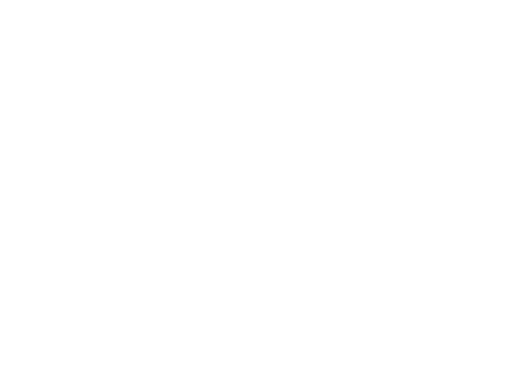

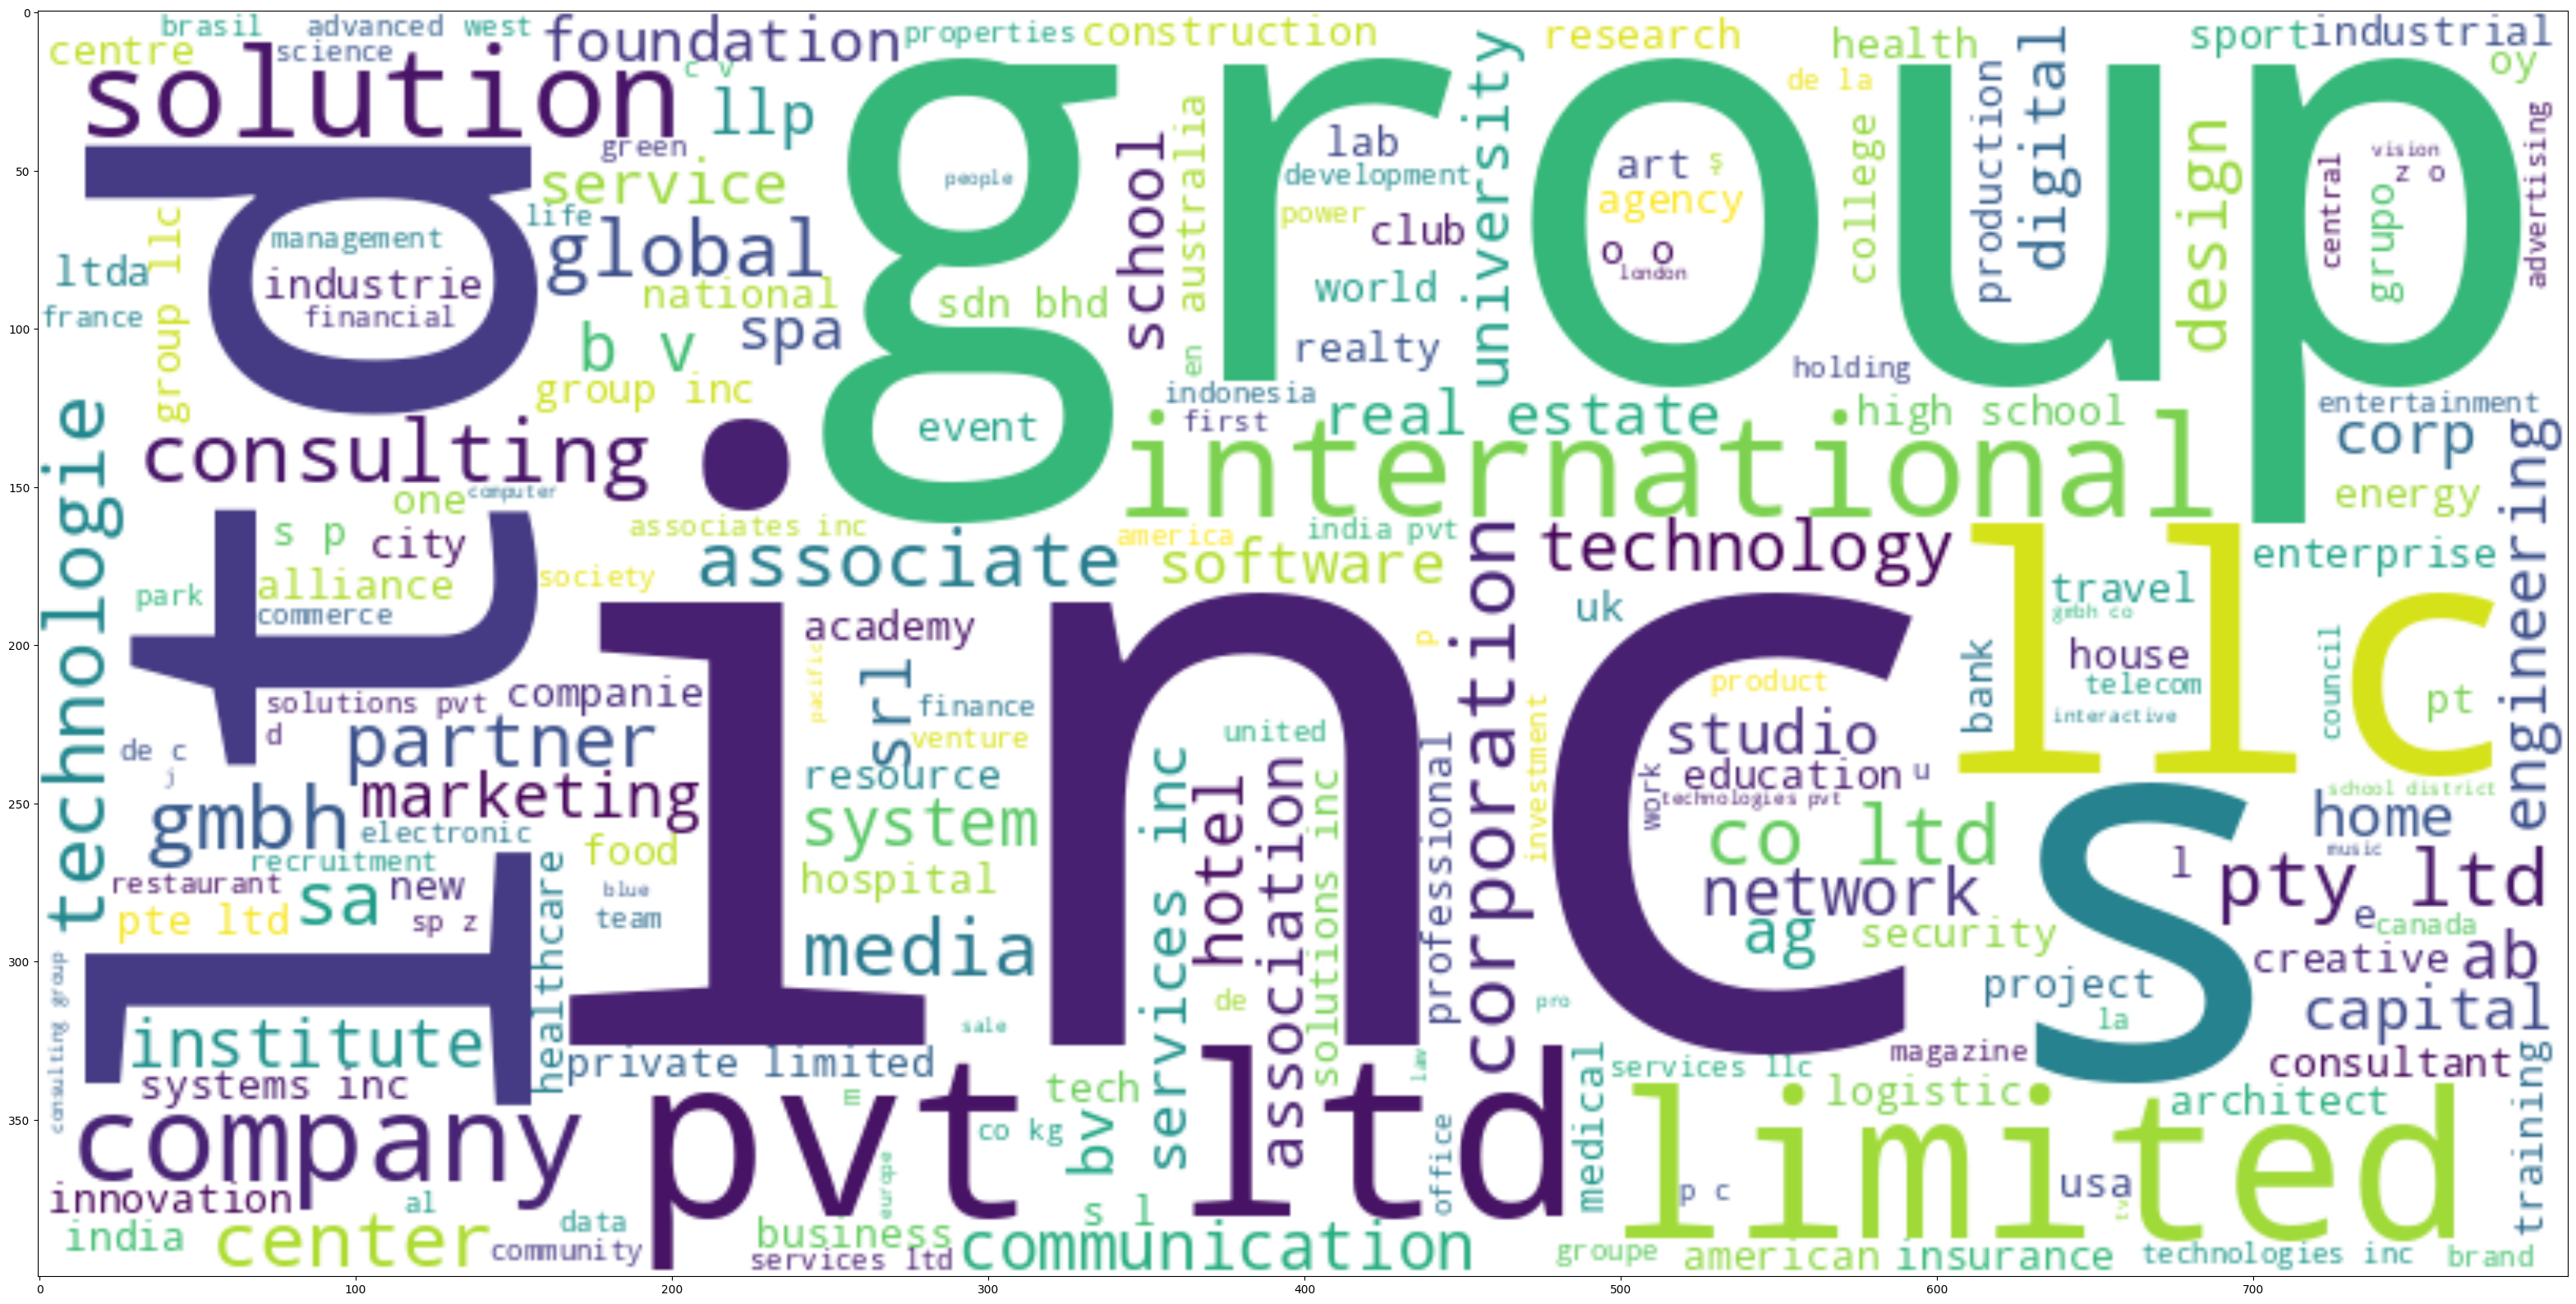

In [58]:
text = " ".join(name for name in df.name)
print ("There are {} words in the combination of all cells in the column 'name'.".format(len(text)))

# generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

# display the word cloud
plt.axis("off")
plt.figure(figsize=(40,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

We can conclude the following from the word cloud.
* The most common words are related to company structure like pvt, ltd, limited, llc, co, inc, group, and gmbh.
* Country and industry names are also frequent.
* Even though they are not frequent companies use single characters like s, b and v in their names. I assume that these characters are abbreviations and are mmostly followed by a peried(.).

### Domain

In [59]:
# unique value counts
counts_df = df['domain'].value_counts().rename_axis('domain').reset_index(name='count')
counts_df

domain  count
0              focusonithemba.org      3
1                     rtfruit.com      3
2                     noterly.com      2
3                 conectamedia.cl      2
4              gatsbyentgroup.com      2
...                           ...    ...
439053    fotografiboccadasse.com      1
439054         nowherestudios.com      1
439055  categorymanagement.com.ar      1
439056            regenesis.co.uk      1
439057              furuno.com.cy      1

[439058 rows x 2 columns]

In [60]:
df[df['domain'] == 'dunked.com']

Empty DataFrame
Columns: [name, domain, year founded, industry, size range, locality, country, linkedin url, current employee estimate, total employee estimate]
Index: []

We can see that there are companies with the same domain but different name. I assume that there was an error while collecting this data or the data was imputed using some criterea. I am saying this because even sister companies have different domains most of the times. Besides this for example companies with the domain 'dunked.com' are from different countries as shown above. This shows that there is low probability of them being sister companies. But since our objective doesn't focus on the domain, we will not drop them.

### Year founded

In [61]:
# unique value counts
counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')
counts_df

year founded   count
0               0  169605
1            2010   13801
2            2009   13202
3            2012   13046
4            2011   12451
..            ...     ...
214          1816       6
215          1808       6
216          1824       6
217          1809       6
218          1813       6

[219 rows x 2 columns]

As shown above there are some historical companies founded before 1900s. Besides this 0 is the most common value because we have repaced null values with it. Let us examine how many companies were founded before the 20th century.

In [62]:
df.query("0 < `year founded` < 1900")['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')

year founded  count
0           1898    162
1           1895    143
2           1889    137
3           1896    135
4           1888    128
..           ...    ...
94          1808      6
95          1824      6
96          1809      6
97          1816      6
98          1813      6

[99 rows x 2 columns]

It seems that there are some companies founded in the 19th century. What about before the 19th century?

In [63]:
df.query("0 < `year founded` < 1800")['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')

Empty DataFrame
Columns: [year founded, count]
Index: []

Earlier we have disovered that the maximum value is 2103. Let us check for vaules bigger than the current year.

In [64]:
df[df['year founded'] > 2021]

Empty DataFrame
Columns: [name, domain, year founded, industry, size range, locality, country, linkedin url, current employee estimate, total employee estimate]
Index: []

Let us remove these records.

In [65]:
df.drop(df.index[df['year founded'] > 2021], inplace=True)

Since most companies in the dataset are founded after 1900, let's see their distribution.

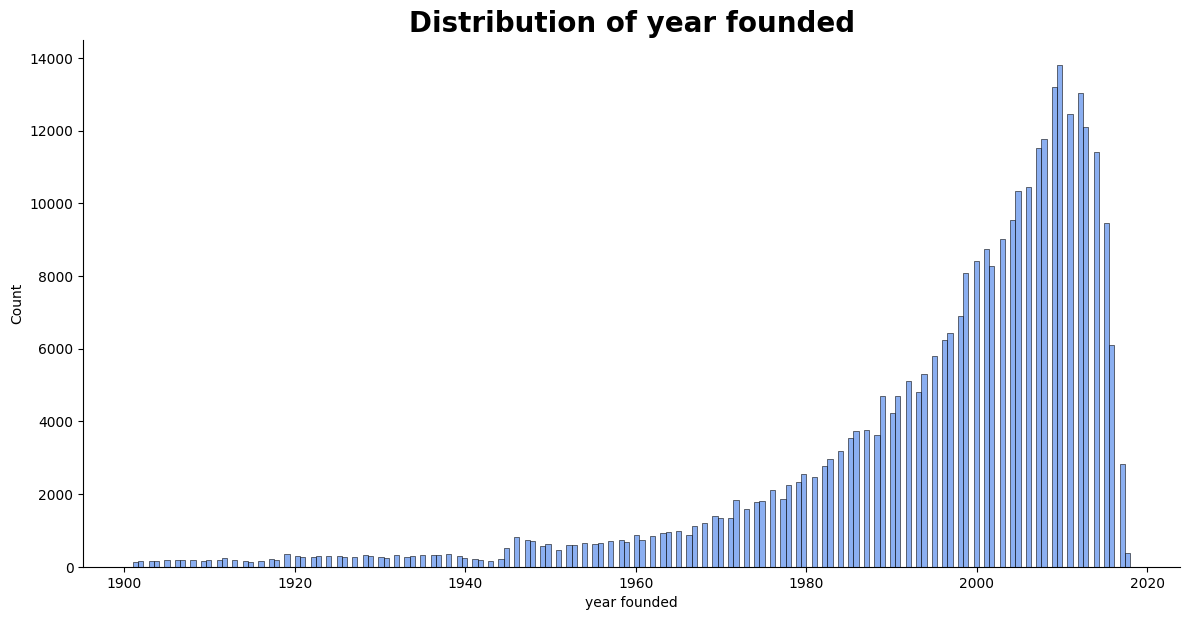

In [66]:
# distribution of companies founded after 1900
plot_dist(df[df['year founded'] > 1900], 'year founded')

### Industry

In [67]:
# unique value counts
counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='count')
counts_df

industry  count
0    information technology and services  36524
1              marketing and advertising  21039
2                           construction  16919
3                      computer software  14986
4                            real estate  14166
..                                   ...    ...
143                              fishery    142
144       alternative dispute resolution    137
145                             ranching    117
146                              tobacco    103
147                   legislative office     46

[148 rows x 2 columns]

The companies in this dataset work in 148 industries. The most common industry is 'infomation technoogy and services'.

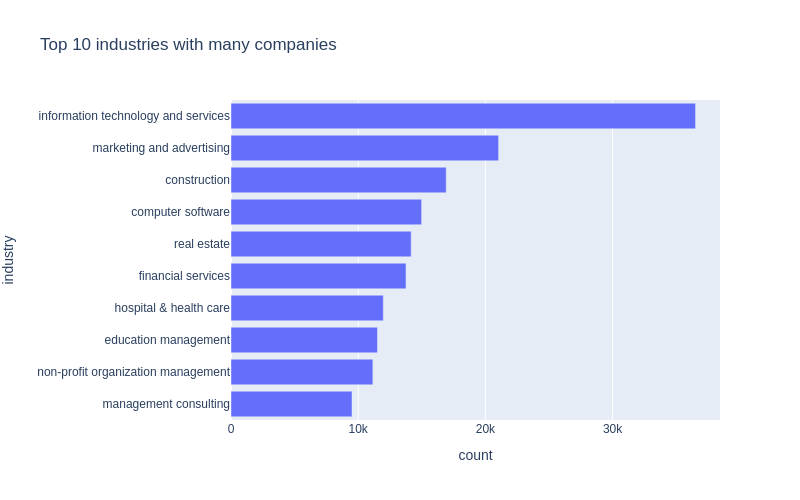

In [68]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with many companies')

### Size range

In [69]:
# unique value counts
counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='count')
counts_df

size range   count
0    11 - 50  475419
1   51 - 200   20697

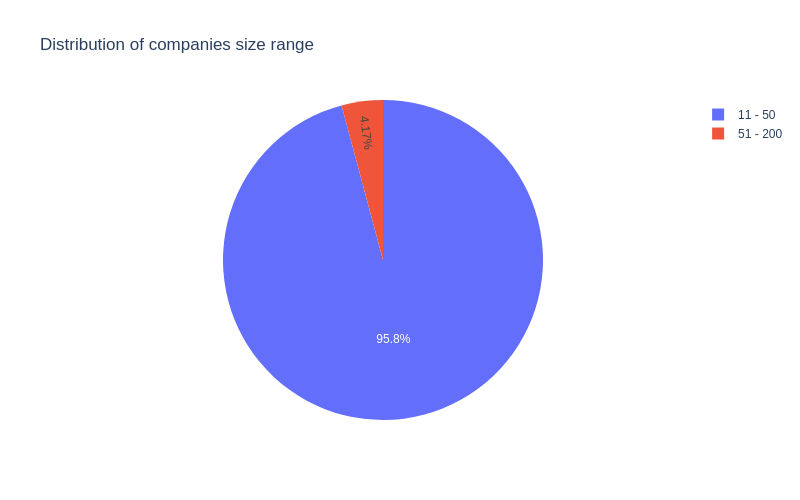

In [70]:
plotly_plot_pie(df, column='size range', title='Distribution of companies size range', width=800)

More than 93% of the companies have employees less than or equal to 50. I think this shows the reaity since the number of big companies that drive economies around the world is small.

### Locality

In [71]:
# unique value counts
counts_df = df['locality'].value_counts().rename_axis('locality').reset_index(name='count')
counts_df

locality  count
0        london, greater london, united kingdom   7026
1             new york, new york, united states   6600
2                         madrid, madrid, spain   4543
3                  paris, île-de-france, france   3623
4              chicago, illinois, united states   2827
...                                         ...    ...
31549    langley, south carolina, united states      1
31550  lake isabella, california, united states      1
31551                  vršac, vojvodina, serbia      1
31552     worthington, minnesota, united states      1
31553               aguadulce, andalusia, spain      1

[31554 rows x 2 columns]

Here we can see that most companies are found in the biggest cities of the developed world like london, new york, madrid and paris. Another thing to notice is that london appears both at index 0 and 4 with slight difference. This shows there is an inconsistency. We will extract the cities as a feature later to fix this.

### Country

In [72]:
# unique value counts
counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='count')
counts_df

country   count
0               united states  165365
1              united kingdom   31839
2                      canada   17787
3                       india   14033
4                 netherlands   13180
..                        ...     ...
216                   mayotte       1
217    svalbard and jan mayen       1
218  central african republic       1
219               timor-leste       1
220                   vanuatu       1

[221 rows x 2 columns]

Here also as expected most companies are from the developes countries.The top 10 countries with many companies are plotted below.

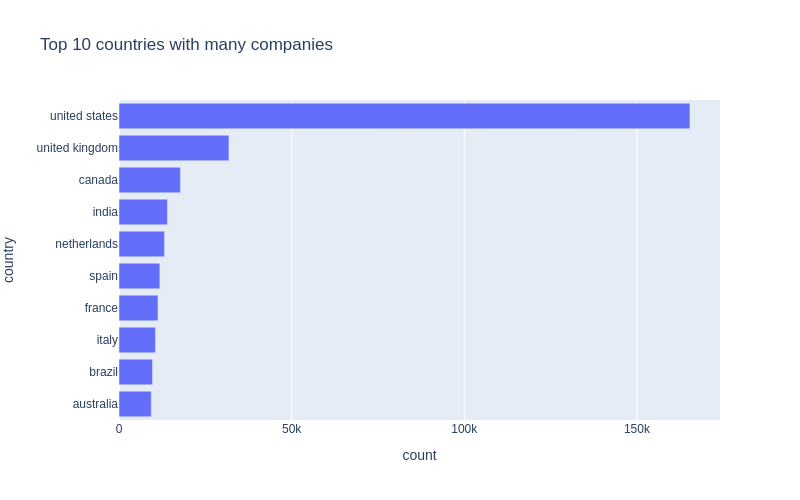

In [73]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='country', title='Top 10 countries with many companies')

 Companies from the united states clearly dominate the dataset.

### Linkedin url

In [74]:
counts_df = df['linkedin url'].value_counts().rename_axis('linkedin url').reset_index(name='count')
counts_df

linkedin url  count
0           linkedin.com/company/stella-nova-technologies      1
1             linkedin.com/company/verbo-educacional-ltda      1
2                       linkedin.com/company/greater-than      1
3                     linkedin.com/company/atma-education      1
4           linkedin.com/company/lifegen-technologies-llc      1
...                                                   ...    ...
496111  linkedin.com/company/kudo-studio-audio-production      1
496112  linkedin.com/company/ottmann-global-partners-gmbh      1
496113                           linkedin.com/company/llh      1
496114             linkedin.com/company/girlguiding-laser      1
496115          linkedin.com/company/amasya-üniversitesi      1

[496116 rows x 2 columns]

As shown above each company has its own unique linkedin url. This is because the name of the company, which is unique, is included in each url.

### Current employee estimate

In [75]:
counts_df = df['current employee estimate'].value_counts().rename_axis('current employee estimate').reset_index(name='count')
counts_df

current employee estimate  count
0                           9  77186
1                           8  76265
2                          10  64440
3                          11  55114
4                          12  46740
5                          13  40703
6                          14  36051
7                          15  31939
8                          16  28671
9                          17  25418
10                         18  13589

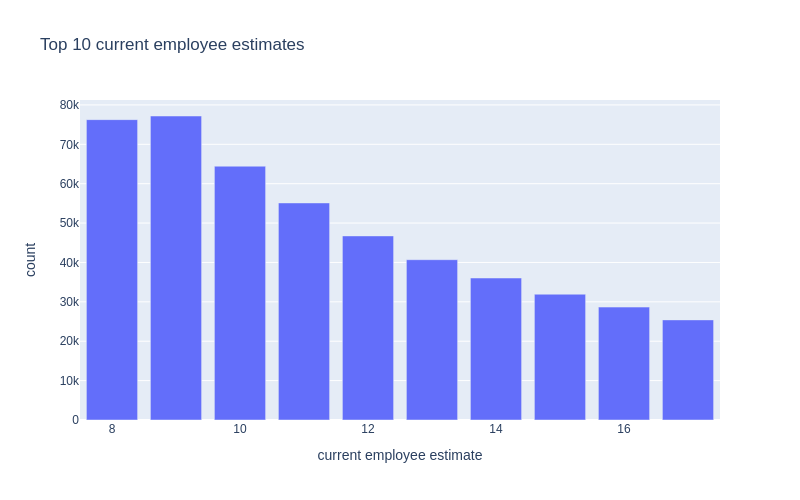

In [76]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='current employee estimate', y='count', title='Top 10 current employee estimates')

Everything seems fine here except for companies with 0 current employee estimate. I assume the data was not available for this companies so 0 was filled as an indication for missing.

### Total employee estimate

In [77]:
counts_df = df['total employee estimate'].value_counts().rename_axis('total employee estimate').reset_index(name='count')
counts_df

total employee estimate  count
0                         16  20938
1                         15  20870
2                         17  20611
3                         18  20487
4                         14  20395
..                       ...    ...
538                      587      1
539                     1507      1
540                      425      1
541                      515      1
542                      501      1

[543 rows x 2 columns]

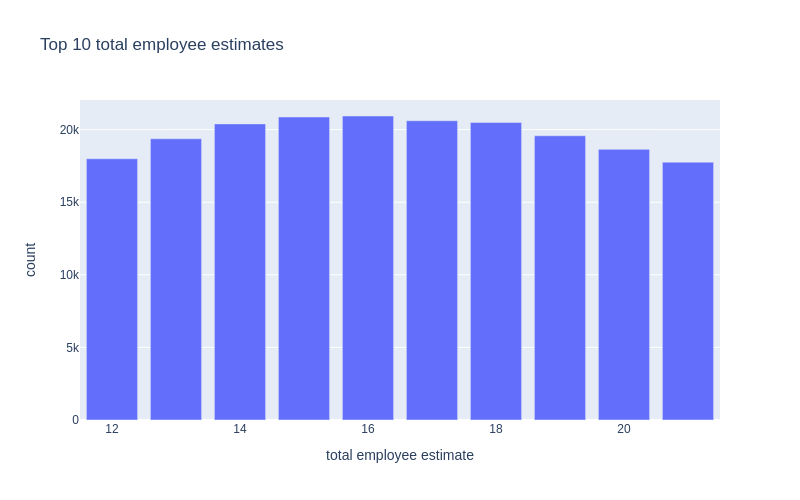

In [78]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='total employee estimate', y='count', title='Top 10 total employee estimates')

Here 0 is the mode value for total employee estimate. I assume this is also due to missing data.

## Feature Engineering

From the locality column we can extract city which is useful to tackle the inconsistency discussed above in the univariate analysis of locality.

In [79]:
def extract_city(locality):
    if pd.isnull(locality):
        return '<NA>'
    # extract cities from locality
    geo = geotext.GeoText(locality).cities
    if len(geo) > 0:
        return geo[0]
    return locality.split(',')[0]

df['city'] = df['locality'].apply(extract_city)

From the name we can extract different features like number of characters, words and punctuations. Another feature to be considered is word density. We can also identify if a name contains digits or non-aschii characters.

In [80]:
df['name_char_count'] = df['name'].apply(lambda name: len(name))

# split name based on comma, space or hyphen
df['name_word_count'] = df['name'].apply(lambda name: len(list(filter(lambda x: x!= '', re.split(r',|\s|-', name)))))

df['name_word_density'] = round(df['name_word_count'] / df['name_char_count'], 2)

punc = string.punctuation
df['name_punc_count'] = df['name'].apply(lambda x : len([a for a in x if a in punc]))

df['name_non_aschii_char_count'] = df['name'].apply(lambda x: len([a for a in x if ord(a) > 127]))

df['name_digit_count'] = df['name'].apply(lambda x: len([a for a in x if a in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]))

For simplicity and ease of calculating correlation I will categorize the values of 'size range' into number values in an another column.

In [81]:
def categorize(size):
    switcher={
        '1 - 10': 1,
        '11 - 50': 2,
        '51 - 200': 3,
        '201 - 500': 4,
        '501 - 1000': 5,
        '1001 - 5000': 6,
        '5001 - 10000': 7,
        '10001+': 8
    }
    return switcher.get(size, 0)
df['size_category'] = df['size range'].apply(categorize)

In [82]:
df.sample(5)

name              domain  \
423111       signature properties of huntington        sphhomes.com   
145096                       datscha uk limited       datscha.co.uk   
389054             little angels nursery school  littleangelsns.com   
434949  benson, pantello, morris, james & logan           bpmjl.com   
393278                         tracy yap realty     tracyyap.com.au   

        year founded                             industry size range  \
423111             0                          real estate    11 - 50   
145096             0  information technology and services    11 - 50   
389054             0                 education management    11 - 50   
434949          1983                         law practice    11 - 50   
393278          1994                          real estate    11 - 50   

                                      locality         country  \
423111     huntington, new york, united states   united states   
145096  london, greater london, united kingdom  united kingdom   
389054   ballston spa, new york, united states   united states   
434949      fort wayne, indiana, united states   united states   
393278      epping, new south wales, australia       australia   

                                             linkedin url  \
423111  linkedin.com/company/signature-properties-of-h...   
145096                linkedin.com/company/datscha-uk-ltd   
389054  linkedin.com/company/little-angels-nursery-school   
434949  linkedin.com/company/benson-pantello-morris-ja...   
393278              linkedin.com/company/tracy-yap-realty   

        current employee estimate  total employee estimate          city  \
423111                          9                       14    huntington   
145096                         13                       18        london   
389054                          9                       11  ballston spa   
434949                          8                       11    fort wayne   
393278                          9                       17        epping   

        name_char_count  name_word_count  name_word_density  name_punc_count  \
423111               34                4               0.12                0   
145096               18                3               0.17                0   
389054               28                4               0.14                0   
434949               39                6               0.15                4   
393278               16                3               0.19                0   

        name_non_aschii_char_count  name_digit_count  size_category  
423111                           0                 0              2  
145096                           0                 0              2  
389054                           0                 0              2  
434949                           0                 0              2  
393278                           0                 0              2

## Correlation Analysis

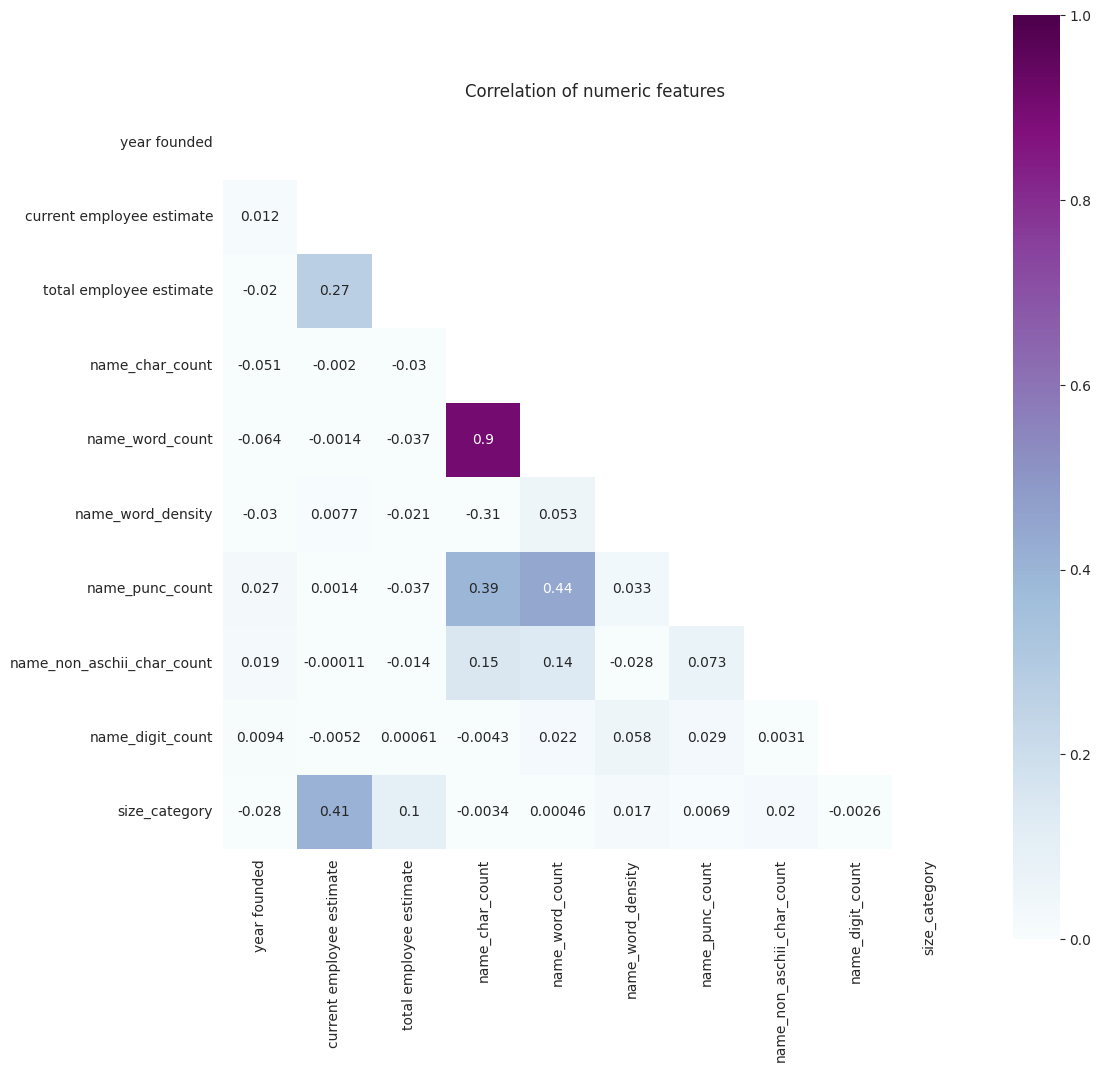

In [83]:
df_corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f_fig, f_ax = plt.subplots(figsize=(12, 12))
    f_ax = sns.heatmap(df_corr, mask=mask, vmin=0, vmax=1, square=True,
                        annot=True, annot_kws={"size": 10}, cmap="BuPu")
plt.title('Correlation of numeric features')
plt.show()

As shown above there is no significant correlation between important numeric features. It is no surprise that 'current employee estimate' and 'total employee estimate' are highly correlated as they both describe the size of employees in companies. The same applies to numeric features engineered from the column name. They have correlation because they are derived from the same place. Due to these facts our bivariate analysis will mostly focus on non-numerical features and their interaction with the numerical features.

## Bivariate Analysis

### country and name_char_count

Here we will examine the averege number of characters in company names per countries.

In [84]:
country_df = df.groupby('country', as_index=False).agg({'name_char_count': 'mean', 'name': 'count'}).rename(columns={'name_char_count': 'mean_name_char', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_char',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_char'] = country_df['mean_name_char'].astype('int16')
country_df

country  mean_name_char  count
0         China              28   3360
1        Kuwait              26    186
2          Oman              26    176
3          Fiji              26    155
4   Philippines              25   1163
..          ...             ...    ...
94      Denmark              16   3288
95       France              16  11288
96      Iceland              15    117
97      Belarus              15    139
98      Estonia              15    293

[99 rows x 3 columns]

In [85]:
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))[['name', 'geometry']]
gdf.columns = ['country', 'geometry']
gdf.head()

country                                           geometry
0                      Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...
1                  Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...
2                 W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...
3                    Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...
4  United States of America  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [86]:
# remove antarctica
antarctic_index = int(gdf[gdf['country'] == 'Antarctica'].index.values)
gdf = gdf.drop(gdf.index[antarctic_index])

replace = {
    "United States of America": 'United States',
    "Bosnia and Herz.": 'Bosnia And Herzegovina',
    "Central African Rep.": 'Central African Republic',
    "Côte d'Ivoire": 'Côte D’Ivoire',
    "Dominican Rep.": 'Dominican Republic',
    "Dem. Rep. Congo": 'Democratic Republic Of The Congo',
    "Eq. Guinea": 'Equatorial Guinea',
    "Dominican Rep.": 'Dominican Republic',
    "Solomon Is.": 'Solomon Islands',
    "Trinidad and Tobago": 'Trinidad And Tobago',
    "S. Sudan": 'South Sudan',
}

for (n_old, n_new) in replace.items():
    gdf.country.loc[gdf['country'] == n_old] = n_new

# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_char     count  
0            26.0     155.0  
1             NaN       NaN  
2             NaN       NaN  
3            22.0   17787.0  
4            21.0  165365.0

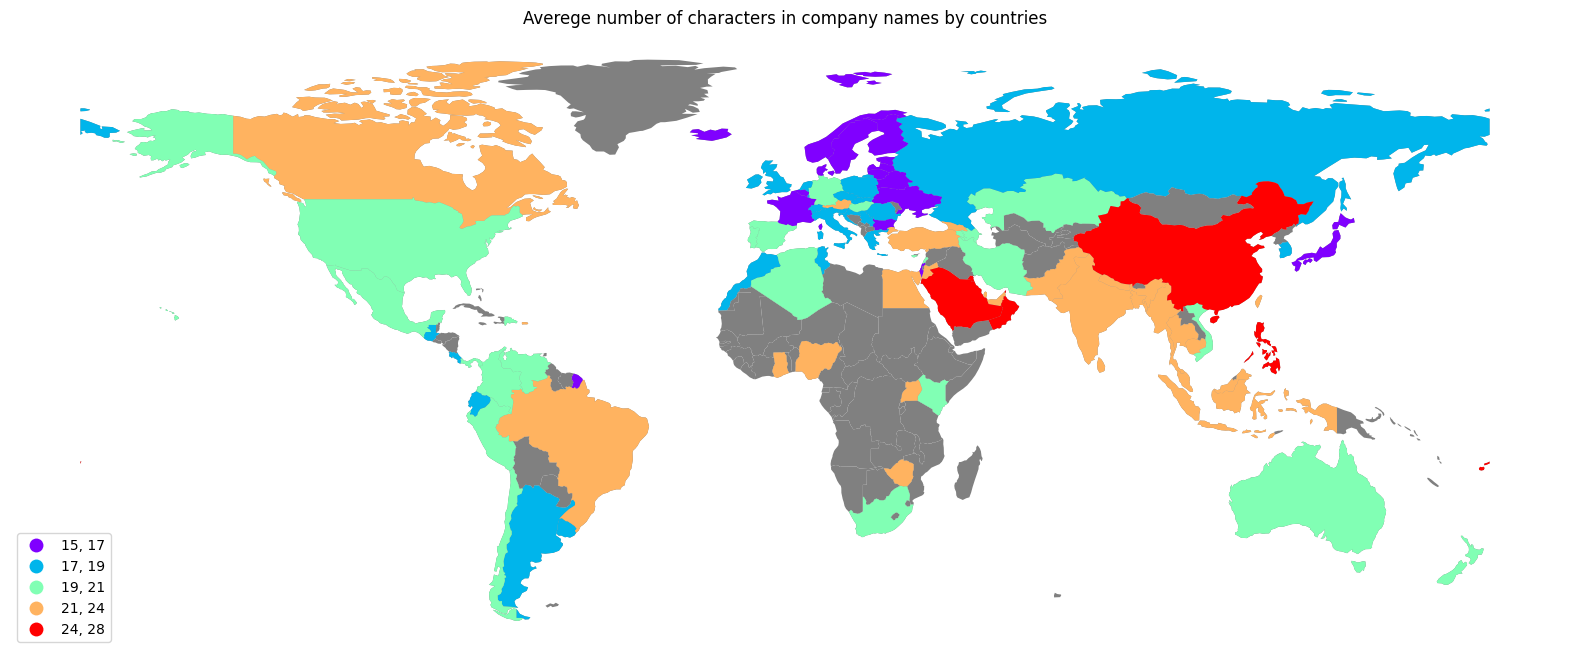

In [91]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_char', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of characters in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

### country and name_word_count

Here we will investigate the averege number of words in company names per countries.

In [92]:
country_df = df.groupby('country', as_index=False).agg({'name_word_count': 'mean', 'name': 'count'}).rename(columns={'name_word_count': 'mean_name_word', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_word',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_word'] = country_df['mean_name_word'].astype('int16')
country_df

country  mean_name_word  count
0       China               4   3360
1        Oman               3    176
2      Kuwait               3    186
3        Fiji               3    155
4    Malaysia               3   1235
..        ...             ...    ...
94  Lithuania               2    450
95     France               2  11288
96    Estonia               2    293
97    Iceland               2    117
98    Belarus               2    139

[99 rows x 3 columns]

In [93]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_word     count  
0             3.0     155.0  
1             NaN       NaN  
2             NaN       NaN  
3             3.0   17787.0  
4             3.0  165365.0

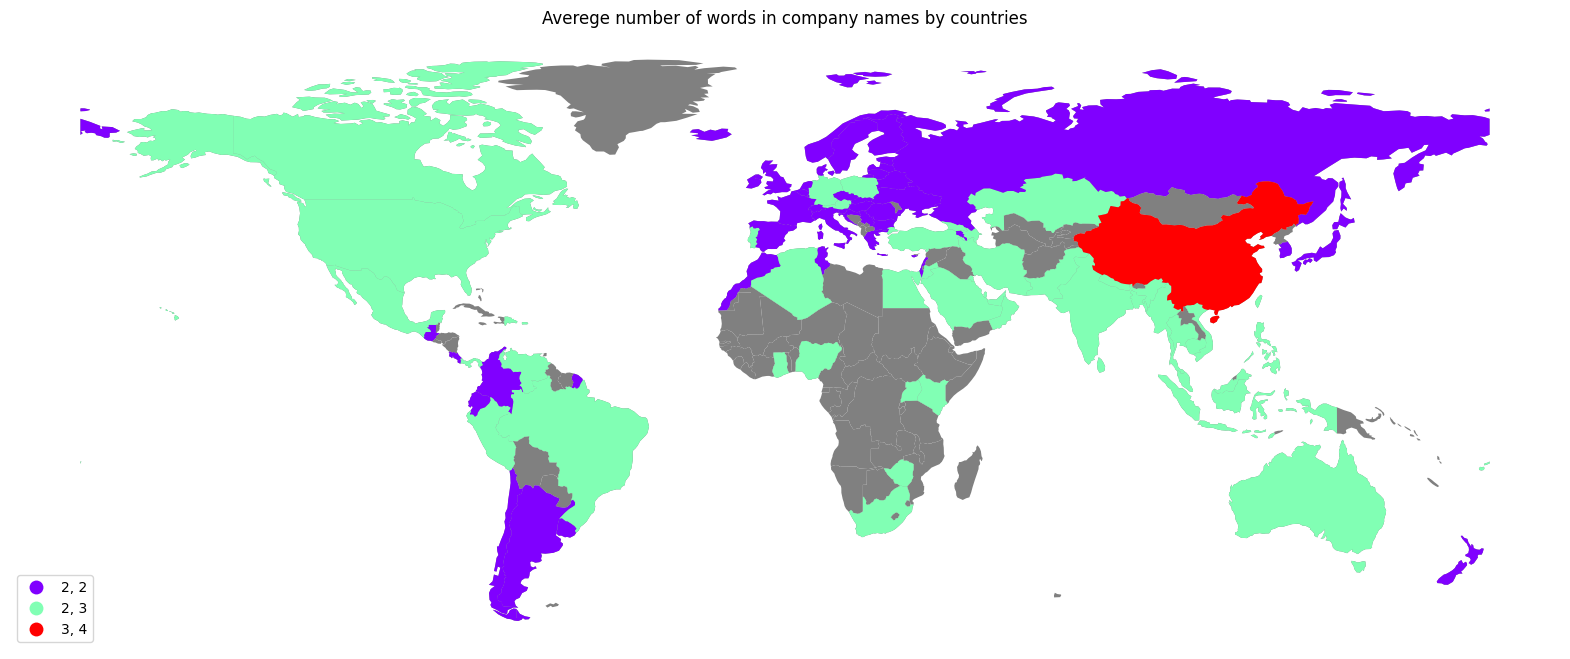

In [94]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_word', cmap='rainbow', ax=ax, scheme='natural_breaks', k=3, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of words in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

There is high similarity with the map showing averege number of characters in company names by countries. It is obvious as there is a correlation between number of characters and words. Some countries with high average number of characters have medium average number of words. I assume the words used by these countries are longer.

### country and name_punc_count

Now it is time for investigating the averege number of punctuations in company names per countries.

In [95]:
country_df = df.groupby('country', as_index=False).agg({'name_punc_count': 'mean', 'name': 'count'}).rename(columns={'name_punc_count': 'mean_name_punct_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_punct_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_punct_count'] = country_df['mean_name_punct_count'].round(2)
country_df

country  mean_name_punct_count  count
0          Czechia                   1.66   1391
1         Slovenia                   1.37    326
2            China                   1.34   3360
3         Slovakia                   1.34    416
4          Croatia                   1.27    408
..             ...                    ...    ...
94  United Kingdom                   0.22  31839
95     New Zealand                   0.22   1945
96         Estonia                   0.18    293
97          Norway                   0.17   2715
98          Sweden                   0.14   4153

[99 rows x 3 columns]

In [96]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_punct_count     count  
0                   0.58     155.0  
1                    NaN       NaN  
2                    NaN       NaN  
3                   0.49   17787.0  
4                   0.55  165365.0

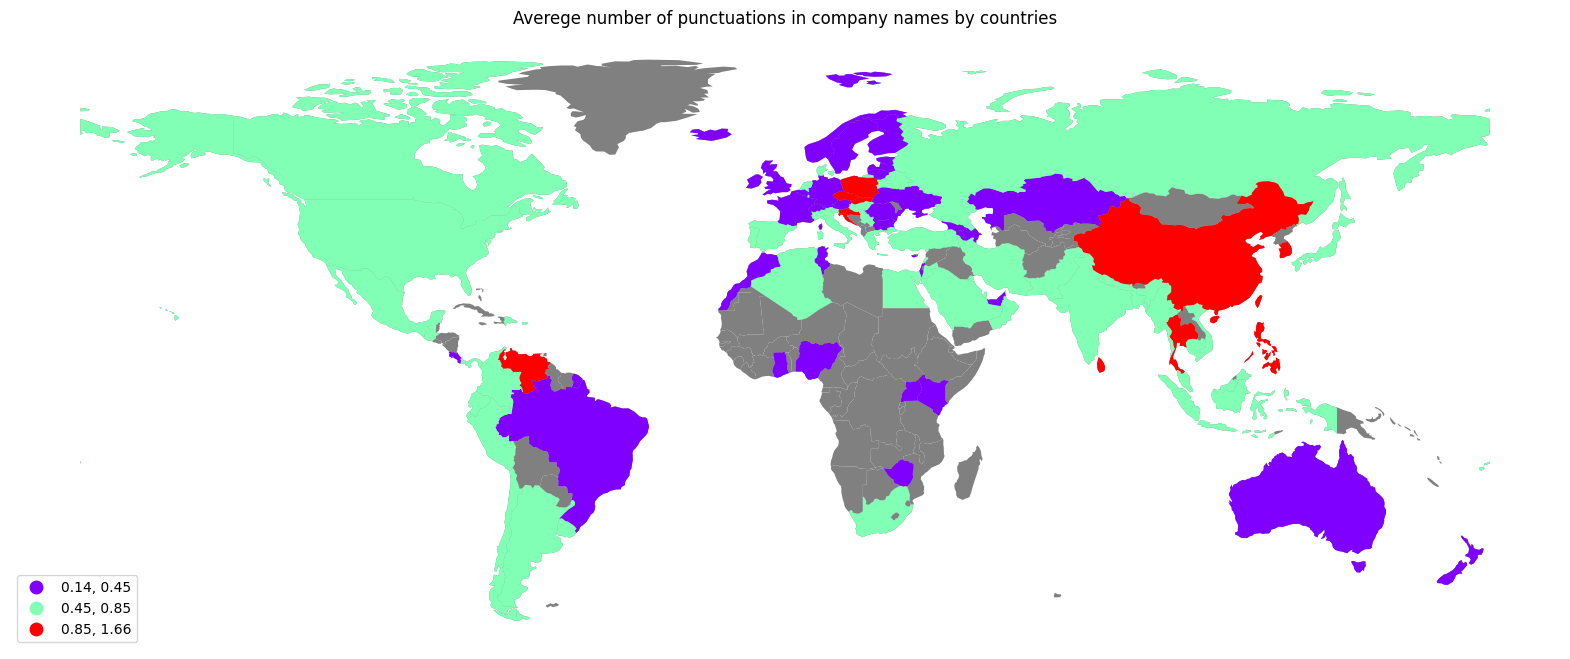

In [97]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_punct_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=3, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of punctuations in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

Some countries in europe, the south east asia and south america have company names with a high probability of including a punctuation. Let's see who they are.

In [98]:
country_df[country_df['mean_name_punct_count'] >= 1]

country  mean_name_punct_count  count
0    Czechia                   1.66   1391
1   Slovenia                   1.37    326
2      China                   1.34   3360
3   Slovakia                   1.34    416
4    Croatia                   1.27    408
5  Venezuela                   1.14    336
6     Poland                   1.05   2219
7     Taiwan                   1.02    403
8   Thailand                   1.01    616

### country and name_digit_count

Digits are not that much common in company name. But they appear in some names to represent something, for example, the year they were founded. Let's see if there is a relation between country and average number of digits in company names.

In [99]:
country_df = df.groupby('country', as_index=False).agg({'name_digit_count': 'mean', 'name': 'count'}).rename(columns={'name_digit_count': 'mean_name_digit_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_digit_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_digit_count'] = country_df['mean_name_digit_count'].round(2)
country_df

country  mean_name_digit_count  count
0        Taiwan                   0.23    403
1   South Korea                   0.17    237
2      Zimbabwe                   0.11    172
3     Venezuela                   0.08    336
4       Bahrain                   0.08    160
..          ...                    ...    ...
94        Ghana                   0.01    172
95         Fiji                   0.01    155
96    Mauritius                   0.00    111
97      Belarus                   0.00    139
98   Azerbaijan                   0.00    127

[99 rows x 3 columns]

The maximum value for average count of digits per country is 0.15 which is very low. This is expected as most company names doesn't include digits.

In [100]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_digit_count     count  
0                   0.01     155.0  
1                    NaN       NaN  
2                    NaN       NaN  
3                   0.05   17787.0  
4                   0.04  165365.0

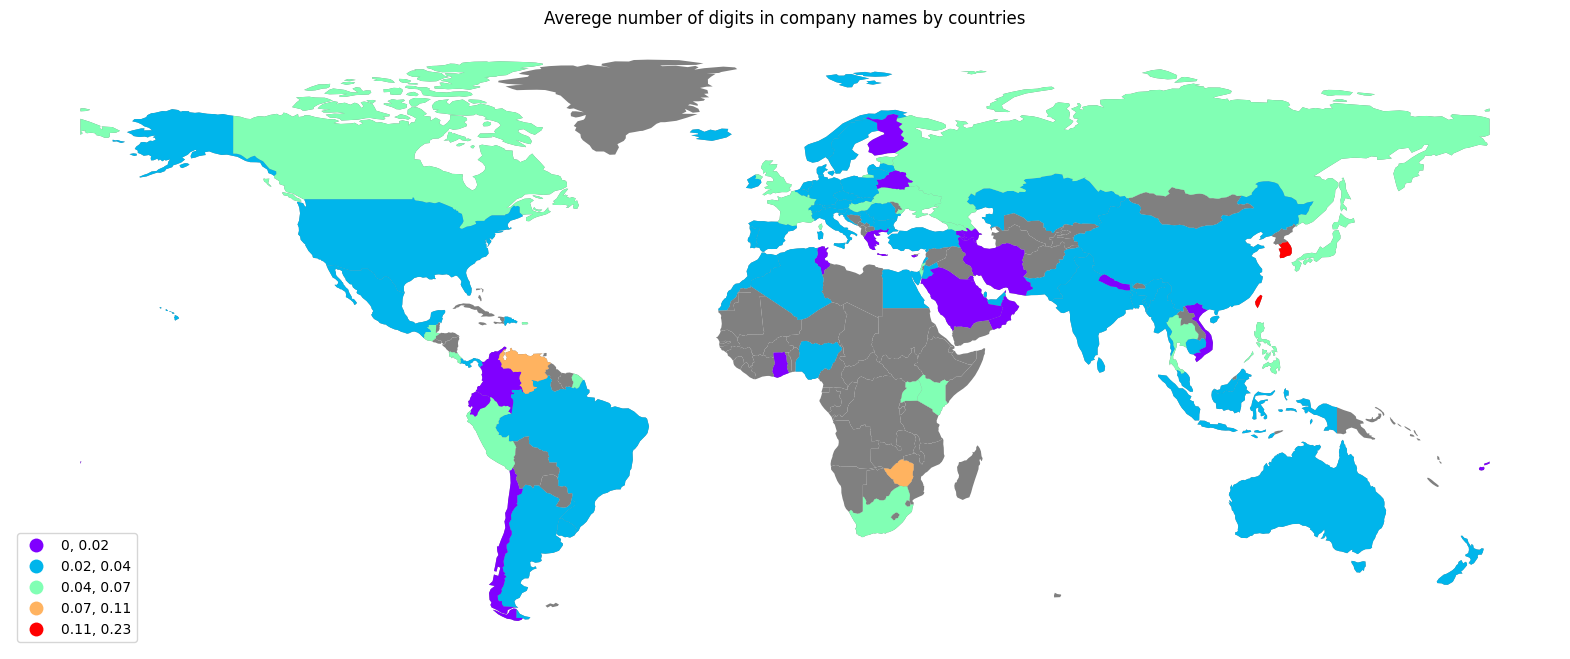

In [101]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_digit_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of digits in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

In [102]:
country_df[country_df['mean_name_digit_count'] > 0.07]

country  mean_name_digit_count  count
0       Taiwan                   0.23    403
1  South Korea                   0.17    237
2     Zimbabwe                   0.11    172
3    Venezuela                   0.08    336
4      Bahrain                   0.08    160

### country and name_non_aschii_char_count

Company names with non-aschii characters are probably going to be from non-english speaking countries. But the question is which countries have the highest number of average non-aschii characters. Let's find out.

In [103]:
country_df = df.groupby('country', as_index=False).agg({'name_non_aschii_char_count': 'mean', 'name': 'count'}).rename(columns={'name_non_aschii_char_count': 'mean_name_non_aschii_char_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_non_aschii_char_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_non_aschii_char_count'] = country_df['mean_name_non_aschii_char_count'].round(2)
country_df

country  mean_name_non_aschii_char_count  count
0         Iran                             1.46    692
1       Russia                             1.35   1506
2   Kazakhstan                             1.27    102
3      Belarus                             1.09    139
4       Turkey                             1.03   3494
..         ...                              ...    ...
94  Bangladesh                             0.00    526
95     Myanmar                             0.00    109
96     Nigeria                             0.00    686
97     Armenia                             0.00    138
98    Zimbabwe                             0.00    172

[99 rows x 3 columns]

In [104]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_non_aschii_char_count     count  
0                             0.58     155.0  
1                              NaN       NaN  
2                              NaN       NaN  
3                             0.08   17787.0  
4                             0.01  165365.0

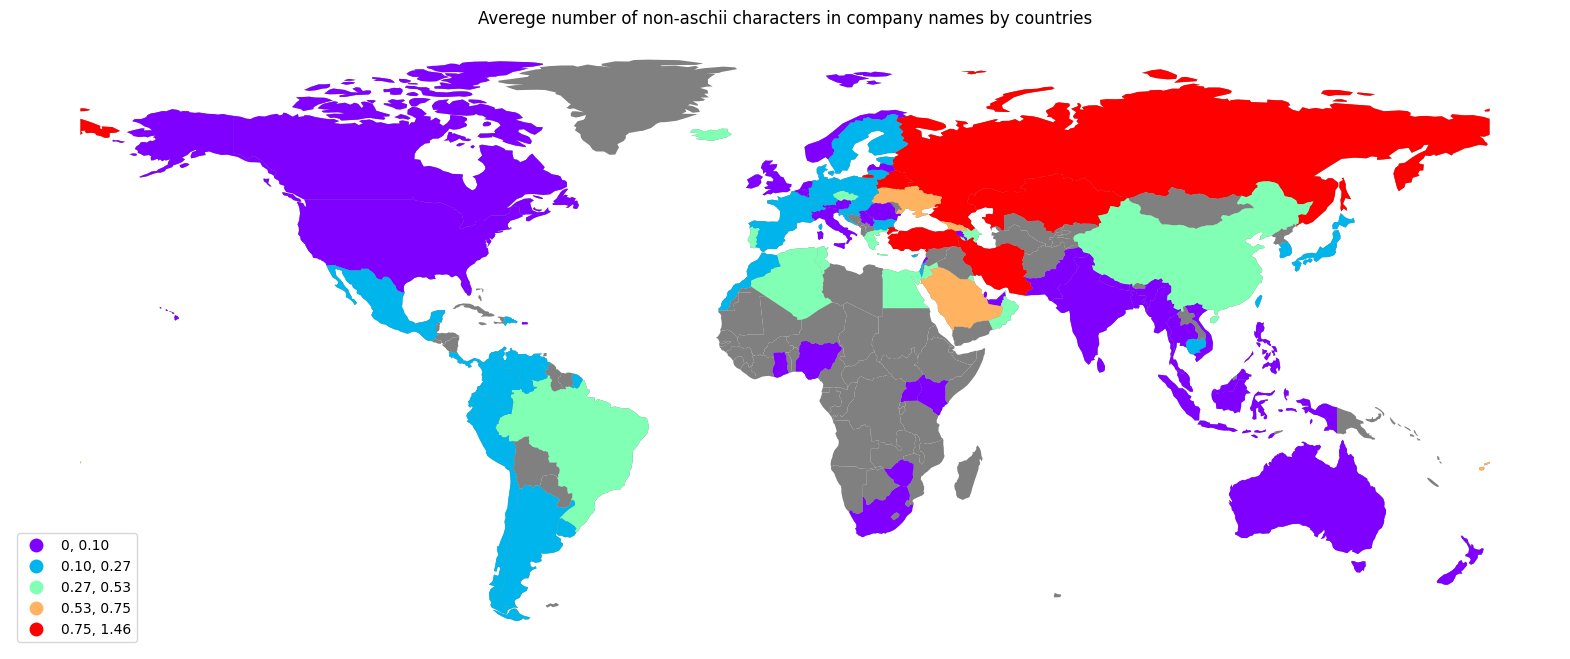

In [105]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_non_aschii_char_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of non-aschii characters in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

Let's find out which countries are coded by red.

In [106]:
country_df[country_df['mean_name_non_aschii_char_count'] >= 0.97]

country  mean_name_non_aschii_char_count  count
0        Iran                             1.46    692
1      Russia                             1.35   1506
2  Kazakhstan                             1.27    102
3     Belarus                             1.09    139
4      Turkey                             1.03   3494

### country and size range

In [107]:
country_df = df.groupby('country', as_index=False).agg({'size_category': 'mean', 'name': 'count'}).rename(columns={'size_category': 'mean_size_category', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_size_category',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_size_category'] = country_df['mean_size_category'].round(2)
country_df

country  mean_size_category   count
0           Uganda                2.13     104
1          Algeria                2.12     132
2        Mauritius                2.12     111
3             Fiji                2.12     155
4         Slovenia                2.11     326
..             ...                 ...     ...
94       Australia                2.00    9342
95  United Kingdom                2.00   31839
96   United States                2.00  165365
97          Canada                2.00   17787
98         Ireland                2.00    2135

[99 rows x 3 columns]

In [108]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_size_category     count  
0                2.12     155.0  
1                 NaN       NaN  
2                 NaN       NaN  
3                2.00   17787.0  
4                2.00  165365.0

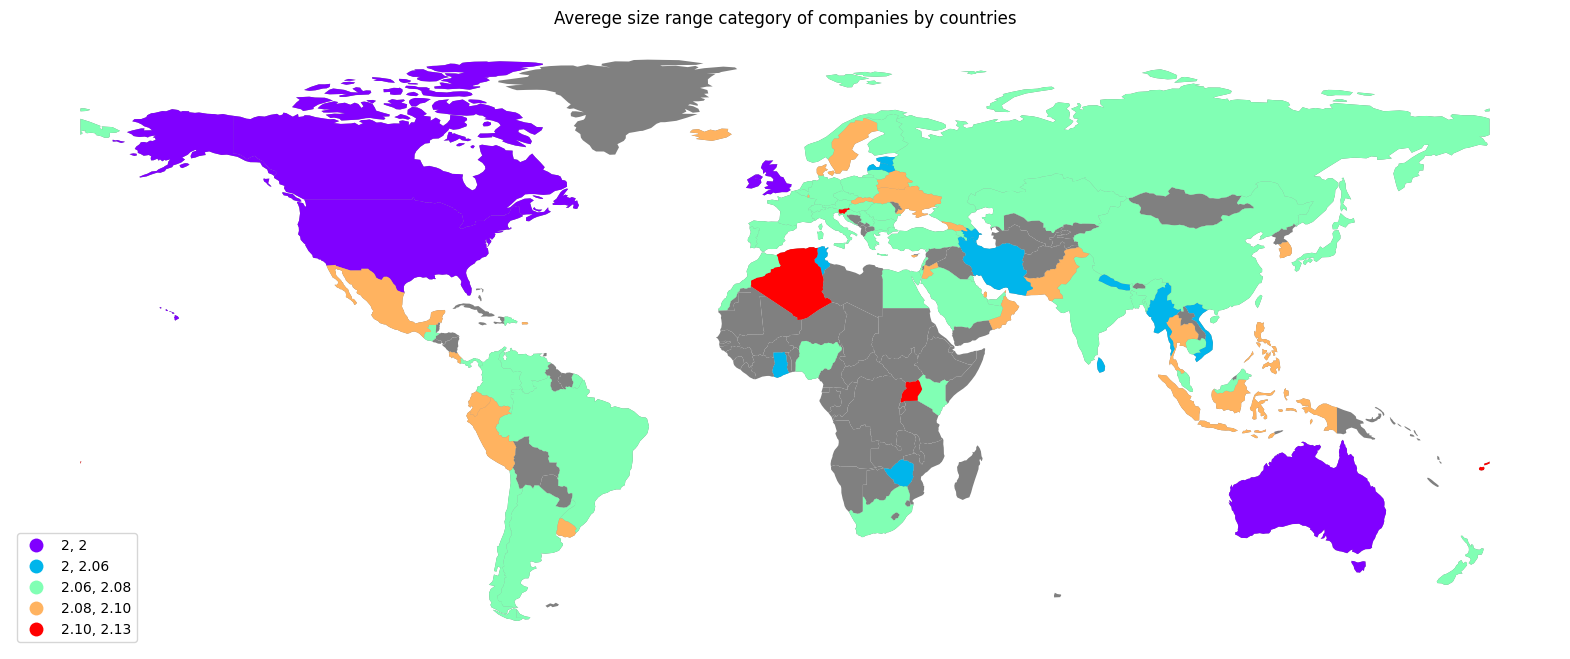

In [109]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_size_category', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege size range category of companies by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

The mean size category ranges from 1.23 to 1.88 in every country with more than or equal to 100 companies in the dataset. This indicates that there are many small companies in these countries which is obvious. That is why the average is lower.

### name and industry

Here we will examine how many and which companies contain words from their respective industries in their names.

In [110]:
def industry_in_name(row):
    puncs = [punc for punc in string.punctuation]
    puncs.append('and')
    industry_words = set(filter(lambda x: x not in puncs, re.split(r'\s|-', row['industry'])))
    name_words = re.split(r'\s|-', row['name'])
    return len([i for i in name_words if i in industry_words])
df['industry_word_in_name_count'] = df.apply(industry_in_name, axis=1)

In [111]:
name_industry_df = df[df['industry_word_in_name_count'] > 0]
name_industry_df

name  \
11                                           awe learning   
53                              aldukheil financial group   
62                                        kips consulting   
98                              highland general hospital   
109                                 sats brf food pte ltd   
...                                                   ...   
499976            c.p.p. printing & direct mail marketing   
499978                             canyon lands insurance   
499994                   saxon textile research institute   
499995                                    secan aerospace   
499997  enigma - adventure tour operator / travel coll...   

                          domain  year founded                   industry  \
11               awelearning.com          1994                 e-learning   
53              aldukheil.com.sa          1979         financial services   
62            kipsconsulting.com          2010      management consulting   
98                          <NA>             0     hospital & health care   
109                  satsbrf.com             0           food & beverages   
...                          ...           ...                        ...   
499976                      <NA>             0                   printing   
499978  canyonlandsinsurance.com          2001                  insurance   
499994                   stfi.de          1992                   research   
499995                      <NA>             0       aviation & aerospace   
499997            enigmaperu.com          2002  leisure, travel & tourism   

       size range                              locality        country  \
11        11 - 50  chester, pennsylvania, united states  united states   
53       51 - 200        riyadh, ar riyāḑ, saudi arabia   saudi arabia   
62       51 - 200   johannesburg, gauteng, south africa   south africa   
98        11 - 50    oakland, california, united states  united states   
109      51 - 200                                  <NA>           <NA>   
...           ...                                   ...            ...   
499976    11 - 50                                  <NA>           <NA>   
499978    11 - 50          mesa, arizona, united states  united states   
499994    11 - 50             chemnitz, saxony, germany        germany   
499995    11 - 50                                  <NA>           <NA>   
499997    11 - 50                    cusco, cusco, peru           peru   

                                             linkedin url  \
11                      linkedin.com/company/awe-learning   
53         linkedin.com/company/aldukheil-financial-group   
62                   linkedin.com/company/kips-consulting   
98         linkedin.com/company/highland-general-hospital   
109                    linkedin.com/company/sats-brf-food   
...                                                   ...   
499976  linkedin.com/company/c.p.p.-printing-&-direct-...   
499978        linkedin.com/company/canyon-lands-insurance   
499994  linkedin.com/company/saxon-textile-research-in...   
499995    linkedin.com/company/linkedin.comsecanaerospace   
499997  linkedin.com/company/enigma-adventure-tour-ope...   

        current employee estimate  total employee estimate          city  \
11                             18                       58       chester   
53                             18                       61        riyadh   
62                             18                       33  johannesburg   
98                             18                       40       oakland   
109                            18                       28          <NA>   
...                           ...                      ...           ...   
499976                          8                        9          <NA>   
499978                          8                       15          mesa   
499994                          8                        9      chemnitz   
499995       

Let's explore these companies with respect to their country, size range, industry and year founded.

#### industry_word_in_name_count and country

In [112]:
country_df = name_industry_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()
country_df

country  count  total_count
0     United States  19546       165365
1    United Kingdom   3291        31839
2            Canada   2181        17787
3             India   1510        14033
4         Australia   1164         9342
..              ...    ...          ...
163         Curaçao      1           23
164         Somalia      1           12
165      Cape Verde      1            7
166    Burkina Faso      1            6
167      Kyrgyzstan      1            7

[168 rows x 3 columns]

In [113]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry    count  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...     23.0   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...     13.0   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...      NaN   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   2181.0   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  19546.0   

   total_count  
0          155  
1           94  
2         <NA>  
3        17787  
4       165365

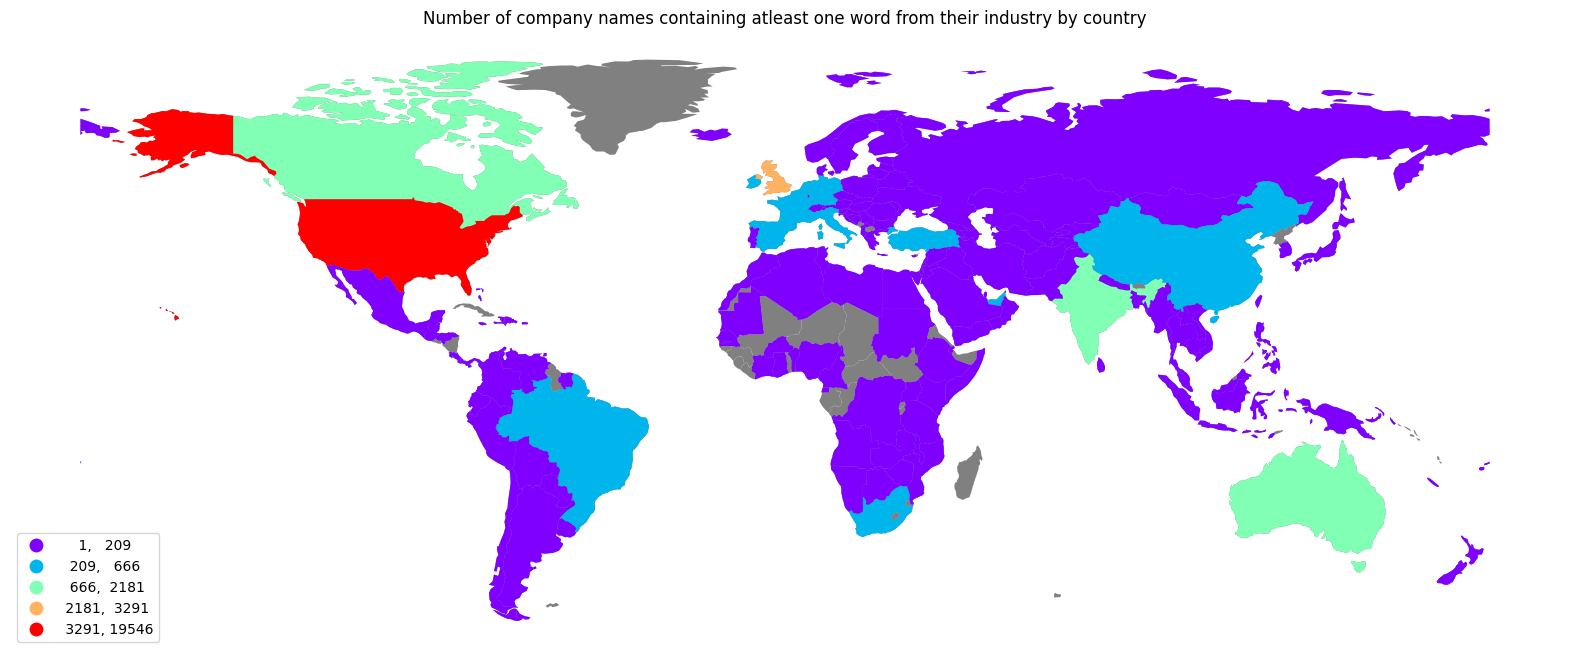

In [114]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing atleast one word from their industry by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

The united states dominates here. But this maybe due to its high number of companies in the dataset as compared to other companies.

#### industry_word_in_name_count and size range

Let us check if these names are related to size range.

In [115]:
size_df = name_industry_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

size range  count  total_count
0    11 - 50  44386       475419
1   51 - 200   1524        20697

As we can see from the result above, small sized companies tend to have more companies with names conataining atleast a word from their respective industries. This aligns with the general distibution of size range. So I don't think there is a special connection here.

#### industry_word_in_name_count and industry

Let us check if these names are related to which industry.

In [116]:
industry_df = name_industry_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
industry_df

industry  count  total_count
0                 hospital & health care   2909        11974
1                              insurance   2525         6733
2              marketing and advertising   2522        21039
3    information technology and services   2367        36524
4                           construction   1909        16919
..                                   ...    ...          ...
140                              fishery      3          142
141               religious institutions      2         2039
142                         supermarkets      1          231
143    nonprofit organization management      1          182
144                             ranching      1          117

[145 rows x 3 columns]

In [117]:
industry_df.head(10)

industry  count  total_count
0               hospital & health care   2909        11974
1                            insurance   2525         6733
2            marketing and advertising   2522        21039
3  information technology and services   2367        36524
4                         construction   1909        16919
5                          real estate   1728        14166
6                   financial services   1691        13758
7                management consulting   1677         9514
8                    computer software   1155        14986
9                         oil & energy   1024         7312

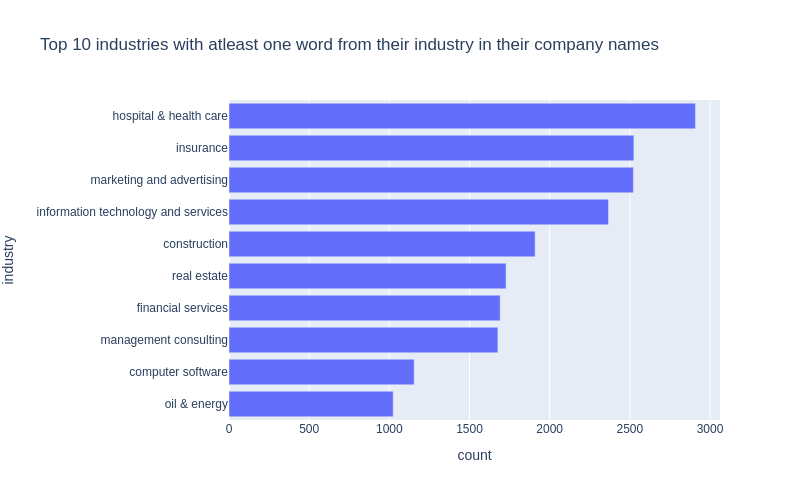

In [118]:
plotly_plot_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with atleast one word from their industry in their company names')

The bar chart plotted above shows top 10 industries with words from their respective industry in their company names.

#### industry_word_in_name_count and year founded

In [119]:
year_df = name_industry_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_df = year_df[year_df['year founded'] != 0]
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
year_df

year founded  count  total_count
0           2010   1365        13801
1           2009   1334        13202
2           2011   1193        12451
3           2007   1163        11531
4           2008   1134        11771
..           ...    ...          ...
185         1846      1           25
186         1859      1           36
187         1858      1           43
188         1853      1           47
189         1801      1            7

[190 rows x 3 columns]

In [120]:
year_df.head(10)

year founded  count  total_count
0         2010   1365        13801
1         2009   1334        13202
2         2011   1193        12451
3         2007   1163        11531
4         2008   1134        11771
5         2012   1133        13046
6         2006   1118        10444
7         2005   1045        10331
8         2013   1030        12109
9         2004   1007         9528

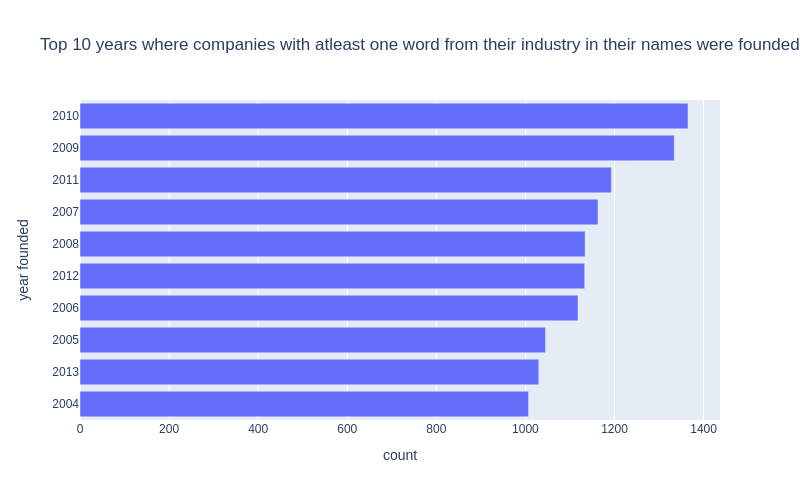

In [121]:
plotly_plot_bar(year_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='year founded', title='Top 10 years where companies with atleast one word from their industry in their names were founded')

### name and locality

Here we will examine how many and which companies contain words from their respective localities in their names.

In [122]:
def locality_in_name(row):
    if pd.isnull(row['locality']):
        return np.nan
    puncs = [punc for punc in string.punctuation]
    puncs.append('and')
    locality_words = set(filter(lambda x: x not in puncs, re.split(r'\s|-', row['locality'])))
    name_words = re.split(r'\s|-', row['name'])
    return len([i for i in name_words if i in locality_words])
df['locality_word_in_name_count'] = df.apply(locality_in_name, axis=1)

In [123]:
name_locality_df = df[df['locality_word_in_name_count'] > 0]
name_locality_df

name  \
40                          plastienvases, s. a. de c. v.   
58                                   pesca argentina s.a.   
80                         la porte county public library   
115                                  stern advisory india   
140               vineyard community church greenwood, in   
...                                                   ...   
499757                       australian logistics council   
499915                     colegio de psicólogos de chile   
499960                     united electronics corporation   
499990                                   one africa media   
499997  enigma - adventure tour operator / travel coll...   

                      domain  year founded                     industry  \
40      plastienvases.com.mx          1975                     plastics   
58         pescargentina.com          2006              food production   
80                lapcat.org             0                    libraries   
115           sternindia.com          2012        management consulting   
140              vccindy.org          1993       religious institutions   
...                      ...           ...                          ...   
499757  austlogistics.com.au             0         government relations   
499915  colegiopsicologos.cl          1968  civic & social organization   
499960             uecus.com          2003              defense & space   
499990                  <NA>          2012                     internet   
499997        enigmaperu.com          2002    leisure, travel & tourism   

       size range                                         locality  \
40       51 - 200              tultitlan, estado de mexico, mexico   
58       51 - 200           mar del plata, buenos aires, argentina   
80        11 - 50                 la porte, indiana, united states   
115      51 - 200                          gurgaon, haryana, india   
140       11 - 50                greenwood, indiana, united states   
...           ...                                              ...   
499757    11 - 50  barton, australian capital territory, australia   
499915    11 - 50        providencia, santiago metropolitan, chile   
499960    11 - 50                    davie, florida, united states   
499990    11 - 50            cape town, western cape, south africa   
499997    11 - 50                               cusco, cusco, peru   

              country                                       linkedin url  \
40             mexico     linkedin.com/company/plastienvases-s-a-de-c-v-   
58          argentina          linkedin.com/company/pesca-argentina-s.a.   
80      united states  linkedin.com/company/la-porte-county-public-li...   
115             india          linkedin.com/company/stern-advisory-india   
140     united states  linkedin.com/company/vineyard-community-church...   
...               ...                                                ...   
499757      australia  linkedin.com/company/australian-logistics-council   
499915          chile  linkedin.com/company/colegio-de-psic-logos-de-...   
499960  united states  linkedin.com/company/united-electronics-corpor...   
499990   south africa              linkedin.com/company/one-africa-media   
499997           peru  linkedin.com/company/enigma-adventure-tour-ope...   

        current employee estimate  total employee estimate           city  \
40                             18                       48      tultitlan   
58                             18                       19  mar del plata   
80                             18                       35       la porte   
115                            18                       27        gurgaon   
140                            18                       29      greenwood   
...                           ...                      ...            ...   
499757                          8                       21         barton   
499915                          8                

Let's explore these companies with respect to their country, size range, industry and year founded.

#### locality_word_in_name_count and country

In [124]:
country_df = name_locality_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()
country_df

country  count  total_count
0        United States   4160       165365
1                India   1134        14033
2               Canada    767        17787
3               France    759        11288
4            Australia    719         9342
..                 ...    ...          ...
163               Mali      1            5
164  Equatorial Guinea      1            5
165      Faroe Islands      1           13
166            Moldova      1           51
167           Kiribati      1            4

[168 rows x 3 columns]

In [125]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry   count  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...    25.0   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...    24.0   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...     NaN   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   767.0   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  4160.0   

   total_count  
0          155  
1           94  
2         <NA>  
3        17787  
4       165365

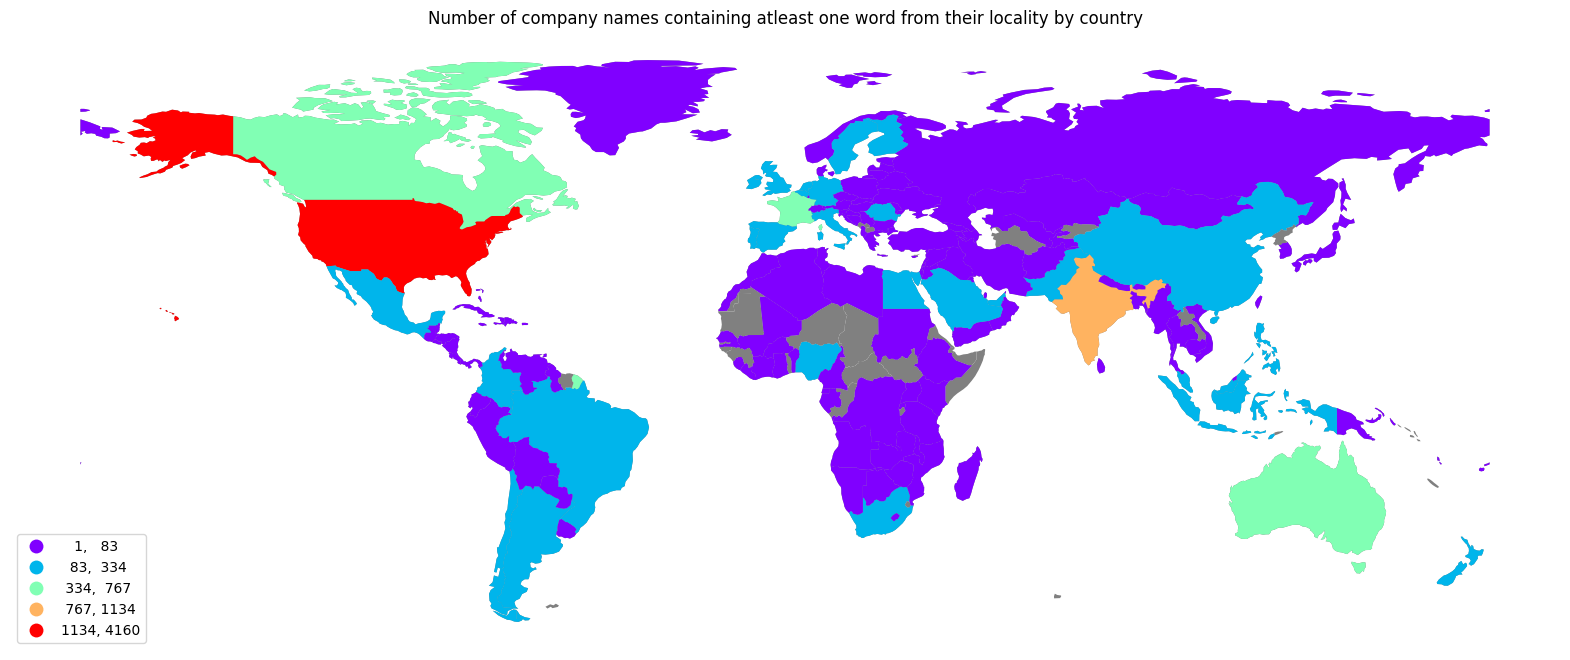

In [126]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing atleast one word from their locality by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

#### locality_word_in_name_count and size range

In [127]:
size_df = name_locality_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

size range  count  total_count
0    11 - 50  13239       475419
1   51 - 200    704        20697

As we can see from the result above, small sized companies tend to have more companies with names conataining atleast a word from their respective localities. This aligns with the general distibution of size range. So I don't think there is a special connection here.

#### locality_word_in_name_count and industry

In [128]:
industry_df = name_locality_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
industry_df

industry  count  total_count
0     non-profit organization management    932        11154
1    information technology and services    703        36524
2                   education management    521        11516
3              marketing and advertising    450        21039
4              government administration    398         3446
..                                   ...    ...          ...
143                              tobacco      4          103
144                             ranching      2          117
145                         supermarkets      2          231
146                   legislative office      2           46
147                       nanotechnology      1          252

[148 rows x 3 columns]

In [129]:
industry_df.head(10)

industry  count  total_count
0   non-profit organization management    932        11154
1  information technology and services    703        36524
2                 education management    521        11516
3            marketing and advertising    450        21039
4            government administration    398         3446
5                           automotive    386         9176
6                          hospitality    385         8224
7                          real estate    369        14166
8               hospital & health care    354        11974
9                   financial services    316        13758

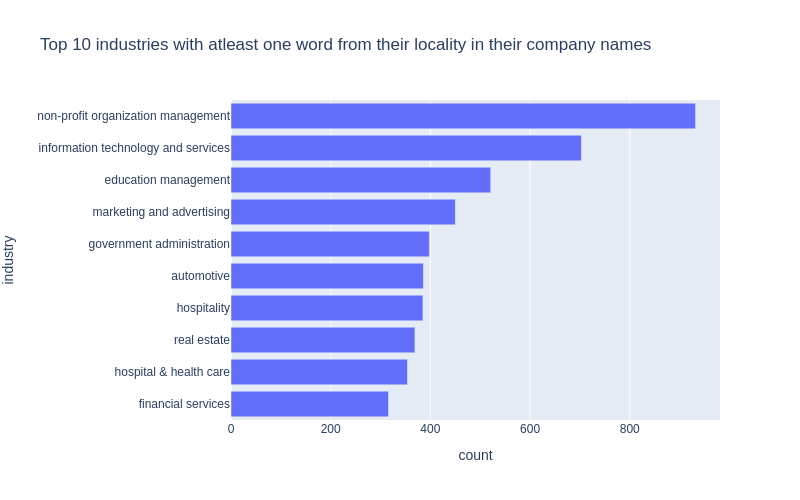

In [130]:
plotly_plot_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with atleast one word from their locality in their company names')

The bar chart plotted above shows top 10 industries with words from their respective locality in their company names.

#### locality_word_in_name_count and year founded

In [131]:
year_df = name_locality_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_df = year_df[year_df['year founded'] != 0]
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
year_df

year founded  count  total_count
0           2012    339        13046
1           2011    331        12451
2           2008    318        11771
3           2009    303        13202
4           2005    296        10331
..           ...    ...          ...
202         1836      1           16
203         1844      1           21
204         1849      1           25
205         1857      1           40
206         1801      1            7

[207 rows x 3 columns]

In [132]:
year_df.head(10)

year founded  count  total_count
0         2012    339        13046
1         2011    331        12451
2         2008    318        11771
3         2009    303        13202
4         2005    296        10331
5         2010    291        13801
6         2006    290        10444
7         2013    285        12109
8         2007    282        11531
9         2004    262         9528

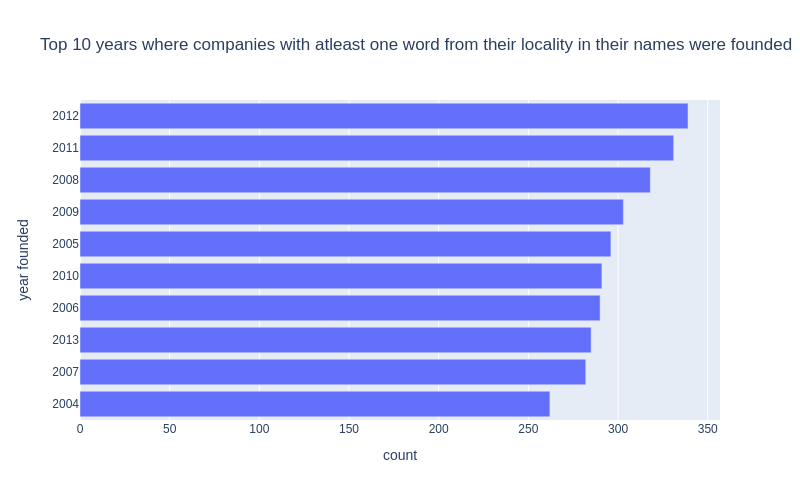

In [133]:
plotly_plot_bar(year_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='year founded', title='Top 10 years where companies with atleast one word from their locality in their names were founded')

### name and year founded

Here we will examine how many and which companies contain words from their respective years they were founded in their names.

In [134]:
def year_in_name(row):
    if (row['year founded'] == 0):
        return None
    year = row['year founded']
    regexp = re.compile(f'{year}')
    return regexp.search(row['name'])

df['year_in_name'] = df.apply(year_in_name, axis=1).astype('bool').astype('int16')

In [135]:
name_year_df = df[df['year_in_name'] > 0]
name_year_df

name  \
4896                             acappella syndicate 2014   
5633                         rite-way fencing (2000) inc.   
8628                                       glass 1989 srl   
18781                                  sportsco est. 1983   
22303   universal1972 | design & manufacturing of tool...   
...                                                   ...   
471332                        medital hi-tech (1992) ltd.   
483798                 inventum, publicitarios desde 1989   
485267            tti climatisation chauffage (2005) inc.   
490128  leadership stage | solutions you can count on ...   
493383  impresa funebre magnani dal 1958 - onoranze po...   

                              domain  year founded  \
4896       acappellaunderwriting.com          2014   
5633              ritewayfencing.com          2000   
8628                    glass1989.it          1989   
18781                sportsco.com.au          1983   
22303              universal1972.com          1972   
...                              ...           ...   
471332                 medital.co.il          1992   
483798                   inventum.es          1989   
485267          tticlimatisation.com          2005   
490128         leadershipstage.co.in          1998   
493383  onoranzefunebrisavignano.com          1958   

                               industry size range  \
4896                          insurance    11 - 50   
5633                       construction    11 - 50   
8628                          furniture   51 - 200   
18781                            retail   51 - 200   
22303                         machinery   51 - 200   
...                                 ...        ...   
471332  business supplies and equipment    11 - 50   
483798        marketing and advertising    11 - 50   
485267                        wholesale    11 - 50   
490128                      think tanks    11 - 50   
493383     individual & family services    11 - 50   

                                      locality         country  \
4896    london, greater london, united kingdom  united kingdom   
5633                  calgary, alberta, canada          canada   
8628                     oderzo, veneto, italy           italy   
18781                                     <NA>            <NA>   
22303                 suzzara, lombardy, italy           italy   
...                                        ...             ...   
471332                                    <NA>            <NA>   
483798            palma, islas baleares, spain           spain   
485267               longueuil, quebec, canada          canada   
490128             bangalore, karnataka, india           india   
493383           cesena, emilia-romagna, italy           italy   

                                             linkedin url  \
4896        linkedin.com/company/acappella-syndicate-2014   
5633      linkedin.com/company/rite-way-fencing-2000-inc-   
8628                       linkedin.com/company/glass1989   
18781           linkedin.com/company/sportsco-head-office   
22303                  linkedin.com/company/universal1972   
...                                                   ...   
471332     linkedin.com/company/medital-hi-tech-1992-ltd.   
483798  linkedin.com/company/inventum-publicitarios-de...   
485267  linkedin.com/company/tti-climatisation-chauffa...   
490128  linkedin.com/company/leadershipstage-kalaanant...   
493383  linkedin.com/company/impresa-funebre-magnani-d...   

        current employee estimate  total employee estimate  ...  \
4896                           18                       26  ...   
5633                           18                       34  ...   
8628                           18                       24  ...   
18781                          17                       76  ...   
22303                          17                       21  ...   
...                           ...                      ...  ...   
471332                     

Let's explore these companies with respect to their country, size range, industry and year founded.

#### year_in_name and country

In [136]:
country_df = name_year_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()
country_df

country  count  total_count
0            Italy     24        10567
1            Spain     12        11837
2    United States     10       165365
3           Canada     10        17787
4   United Kingdom     10        31839
5      Netherlands      4        13180
6           France      3        11288
7          Germany      3         7358
8            India      3        14033
9           Brazil      2         9715
10       Singapore      2         2088
11          Sweden      2         4153
12          Serbia      1          460
13     Switzerland      1         3107
14        Pakistan      1         1074
15        Thailand      1          616
16        Portugal      1         1967
17         Austria      1          968
18          Norway      1         2715
19     New Zealand      1         1945
20         Bahrain      1          160
21         Lebanon      1          385
22          Greece      1          943
23         Georgia      1          137
24      Costa Rica      1          269
25           China      1         3360
26         Belgium      1         4317
27        Zimbabwe      1          172

In [137]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  count  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...    NaN   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...    NaN   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...    NaN   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   10.0   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   10.0   

   total_count  
0         <NA>  
1         <NA>  
2         <NA>  
3        17787  
4       165365

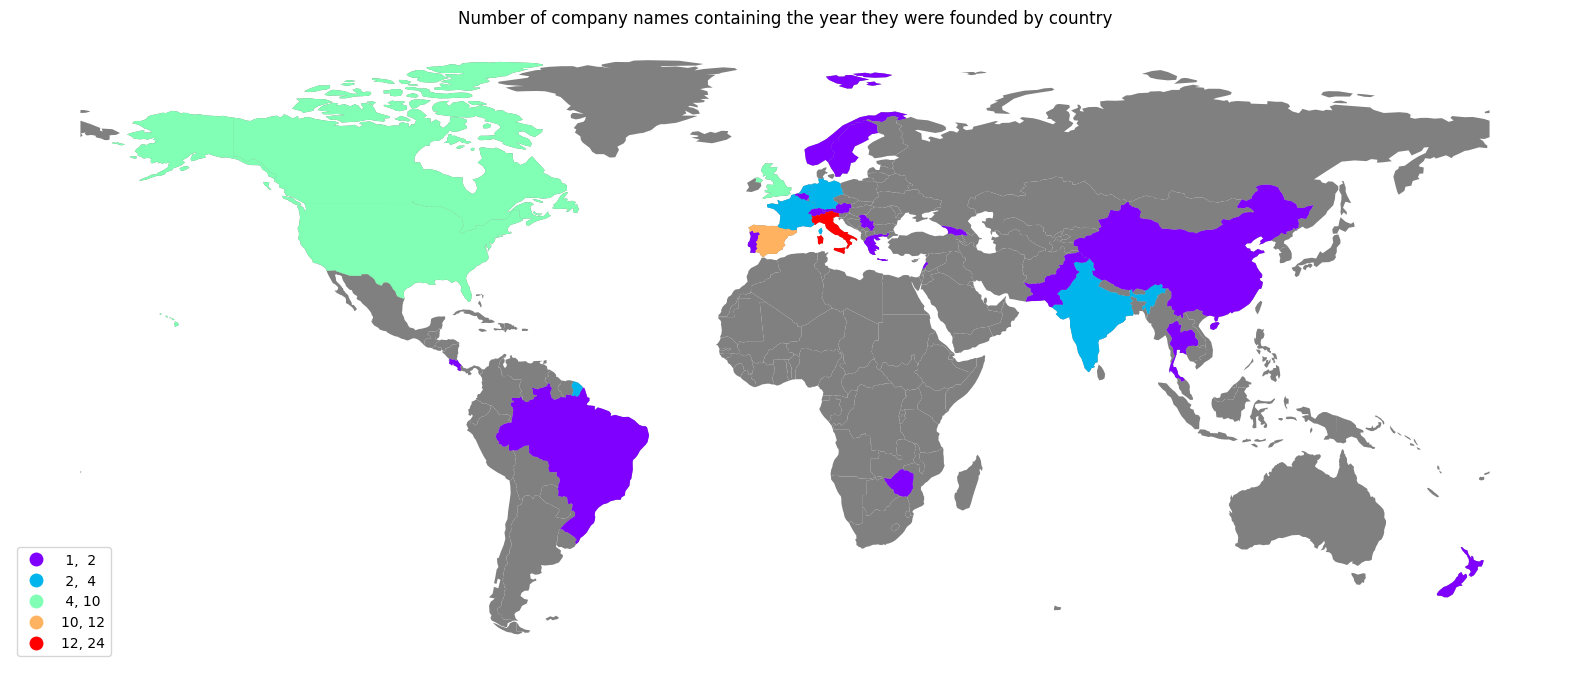

In [138]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing the year they were founded by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

#### year_in_name and size range

Let us check if these names are related to size range.

In [139]:
size_df = name_year_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

size range  count  total_count
0    11 - 50    112       475419
1   51 - 200      7        20697

As we can see from the result above, if a company's name contains the year it was founded the company tends to have a small number of employees. Again this also aligns with the general distibution of size range. So I don't think there is a special connection here.

#### year_in_name and industry

Let us check if these names are related to which industry.

In [140]:
industry_df = name_year_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
industry_df

industry  count  total_count
0                                 sports      7         3735
1                           construction      5        16919
2              marketing and advertising      5        21039
3                        food production      5         3419
4                              furniture      5         2139
5                      apparel & fashion      4         3420
6                               textiles      4         1751
7                              insurance      4         6733
8                            real estate      4        14166
9            primary/secondary education      3         3269
10                      food & beverages      3         5915
11                                retail      3         6412
12       business supplies and equipment      3         2178
13               staffing and recruiting      3         7611
14                    telecommunications      3         7504
15                luxury goods & jewelry      2          837
16                          law practice      2         6289
17                            accounting      2         5237
18                             machinery      2         4855
19                 management consulting      2         9514
20  mechanical or industrial engineering      2         7455
21                       human resources      2         5830
22                              printing      2         2898
23          individual & family services      2         2231
24   information technology and services      2        36524
25                             wholesale      2         3418
26                             chemicals      2         3195
27                                design      2         4812
28                    financial services      2        13758
29                               banking      2         2869
30                     computer software      1        14986
31      professional training & coaching      1         4241
32           civic & social organization      1         2941
33                           restaurants      1         2305
34                        sporting goods      1          892
35           security and investigations      1         2457
36               paper & forest products      1          625
37                            automotive      1         9176
38                       arts and crafts      1          737
39               architecture & planning      1         5139
40                           think tanks      1          609
41                        consumer goods      1         3793
42                hospital & health care      1        11974
43                outsourcing/offshoring      1         1306
44                           hospitality      1         8224
45                             cosmetics      1         1353
46                              maritime      1         1682
47                  education management      1        11516
48                environmental services      1         4315
49                       events services      1         4352
50            logistics and supply chain      1         3943
51                   facilities services      1         2854
52                              internet      1         9465
53   international trade and development      1         1728
54                     airlines/aviation      1         1733
55                  government relations      1          920
56                      higher education      1         4792
57                            newspapers      1         1148

In [141]:
industry_df.head(10)

industry  count  total_count
0                       sports      7         3735
1                 construction      5        16919
2    marketing and advertising      5        21039
3              food production      5         3419
4                    furniture      5         2139
5            apparel & fashion      4         3420
6                     textiles      4         1751
7                    insurance      4         6733
8                  real estate      4        14166
9  primary/secondary education      3         3269

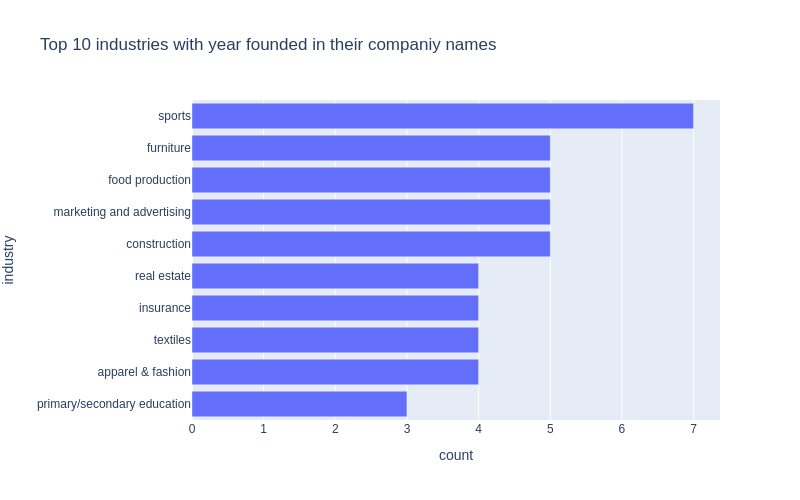

In [142]:
plotly_plot_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with year founded in their companiy names')

The bar chart plotted above shows top 10 industries with year founded in their companiy names. I think that it is obvious that sport companies are very associated with the year they were founded. The table above also proves this. Even though the sports industry has smaller number of companies in the dataset when compared to with the other industries ranking from 2-10, it is ranked as number 1 in the number of companiy names containing the year they were founded.

#### year_in_name and year founded

In [143]:
year_df = name_year_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
year_df

year founded  count  total_count
0          2000     13         8413
1          1989      7         4695
2          1980      4         2539
3          1972      4         1825
4          2009      3        13202
..          ...    ...          ...
65         1958      1          740
66         1959      1          680
67         1965      1          977
68         1817      1            9
69         2014      1        11418

[70 rows x 3 columns]

In [144]:
year_df.head(10)

year founded  count  total_count
0         2000     13         8413
1         1989      7         4695
2         1980      4         2539
3         1972      4         1825
4         2009      3        13202
5         1992      3         5113
6         1993      3         4796
7         1919      3          361
8         1900      3          149
9         1904      2          170

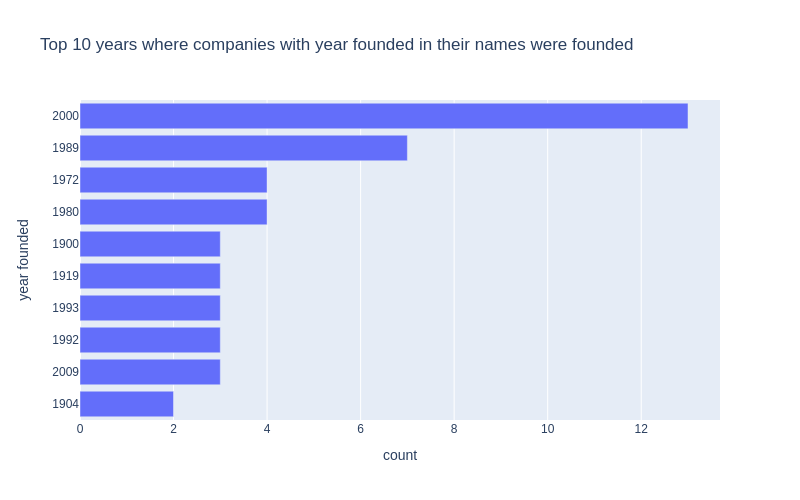

In [145]:
plotly_plot_bar(year_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='year founded', title='Top 10 years where companies with year founded in their names were founded')

Even though the number of companies founded in 2000 in the dataset are relatively smaller, it is ranked as number 1 in the number of company names containing the year they were founded. I think this is because the year 2000 is special as it is the start of a millenium, a year that comes once in a thousand years.

## Filtering Data and Answering Business Questions

### How many and which company names contain stop words?

In [146]:
def stopword_in_name(name):
    # split words in name and replace the & symbol with 'and'
    name_words = re.split(r'\s|-',re.sub('&', ' and ', name))
    return len([i for i in name_words if i in STOPWORDS])
df['stopword_in_name_count'] = df['name'].apply(stopword_in_name)

In [147]:
stopword_df = df[df['stopword_in_name_count'] > 0]
stopword_df

name                domain  \
3                                  greater than ab        greaterthan.eu   
4              atma - an accelerator for education           atma.org.in   
6                                        axdata as            axdata.com   
18              tata realty and infrastructure ltd            tril.co.in   
21                    gertler and wente architects  globaltelecominc.net   
...                                            ...                   ...   
499963                                    depro as              depro.no   
499976     c.p.p. printing & direct mail marketing                  <NA>   
499986                                   get boost           getboost.cz   
499993  hargrove, smelley, strickland, and langley          hssl-law.com   
499996                         the jacques company       jerrykalman.com   

        year founded                             industry size range  \
3               2004  information technology and services   51 - 200   
4               2007   non-profit organization management   51 - 200   
6               1994                    computer software   51 - 200   
18              2006                          real estate   51 - 200   
21                 0              architecture & planning   51 - 200   
...              ...                                  ...        ...   
499963          2005                         oil & energy    11 - 50   
499976             0                             printing    11 - 50   
499986          2014            marketing and advertising    11 - 50   
499993             0                         law practice    11 - 50   
499996             0                          real estate    11 - 50   

                                 locality  country  \
3       stockholm, stockholms lan, sweden   sweden   
4              bombay, maharashtra, india    india   
6            sandefjord, vestfold, norway   norway   
18             bombay, maharashtra, india    india   
21                                   <NA>     <NA>   
...                                   ...      ...   
499963            bryne, rogaland, norway   norway   
499976                               <NA>     <NA>   
499986             prague, praha, czechia  czechia   
499993                               <NA>     <NA>   
499996                               <NA>     <NA>   

                                             linkedin url  \
3                       linkedin.com/company/greater-than   
4                     linkedin.com/company/atma-education   
6                          linkedin.com/company/axdata-as   
18      linkedin.com/company/tata-realty-and-infrastru...   
21      linkedin.com/company/gertler-and-wente-architects   
...                                                   ...   
499963                      linkedin.com/company/depro-as   
499976  linkedin.com/company/c.p.p.-printing-&-direct-...   
499986             linkedin.com/company/game-boost-s-r-o-   
499993  linkedin.com/company/hargrove-smelley-strickla...   
499996           linkedin.com/company/the-jacques-company   

        current employee estimate  total employee estimate  ...  \
3                              18                       28  ...   
4                              18                       91  ...   
6                              18                       29  ...   
18                             18                       25  ...   
21                             18                       48  ...   
...                           ...                      ...  ...   
499963                          8                       17  ...   
499976                          8                        9  ...   
499986                          8                       10  ...   
499993                          8                       26  ...   
499996                          8                       10  ...   

       name_word_count  name_word_density  name_punc_count  \
3                  

There are more than 930,000 companies whose names contain atleast one stop word.

### How many and which company names contain punctuations?

In [148]:
punc_df = df[df['name_punc_count'] > 0]
punc_df

name  \
4                     atma - an accelerator for education   
5                               lifegen technologies, llc   
10                                 shore bancshares, inc.   
20                                      staffinders, inc.   
28                            workforce connections, inc.   
...                                                   ...   
499983                         de pleats - fergees horeca   
499987    strategiya - soluções em comércio exterior e ti   
499988                                        somosur s.l   
499993         hargrove, smelley, strickland, and langley   
499997  enigma - adventure tour operator / travel coll...   

                          domain  year founded  \
4                    atma.org.in          2007   
5                lifegentech.com             0   
10           shorebancshares.com          1996   
20                  sfi-ohio.com          2000   
28      workforceconnections.org          1983   
...                          ...           ...   
499983               depleats.nl          1997   
499987         strategiya.com.br          2004   
499988               somosur.com          2005   
499993              hssl-law.com             0   
499997            enigmaperu.com          2002   

                                   industry size range  \
4        non-profit organization management   51 - 200   
5                             biotechnology    11 - 50   
10                       financial services    11 - 50   
20                  staffing and recruiting    11 - 50   
28       non-profit organization management    11 - 50   
...                                     ...        ...   
499983                          hospitality    11 - 50   
499987  information technology and services    11 - 50   
499988                   telecommunications    11 - 50   
499993                         law practice    11 - 50   
499997            leisure, travel & tourism    11 - 50   

                                      locality        country  \
4                   bombay, maharashtra, india          india   
5            madison, wisconsin, united states  united states   
10             easton, maryland, united states  united states   
20           independence, ohio, united states  united states   
28         la crosse, wisconsin, united states  united states   
...                                        ...            ...   
499983          burgum, friesland, netherlands    netherlands   
499987  rio de janeiro, rio de janeiro, brazil         brazil   
499988             aguadulce, andalusia, spain          spain   
499993                                    <NA>           <NA>   
499997                      cusco, cusco, peru           peru   

                                             linkedin url  \
4                     linkedin.com/company/atma-education   
5           linkedin.com/company/lifegen-technologies-llc   
10             linkedin.com/company/shore-bancshares-inc-   
20                  linkedin.com/company/staffinders-inc-   
28        linkedin.com/company/workforce-connections-inc-   
...                                                   ...   
499983    linkedin.com/company/de-pleats---fergees-horeca   
499987  linkedin.com/company/strategiya---soluções-em-...   
499988                   linkedin.com/company/somosur-s-l   
499993  linkedin.com/company/hargrove-smelley-strickla...   
499997  linkedin.com/company/enigma-adventure-tour-ope...   

        current employee estimate  total employee estimate  ...  \
4                              18                       91  ...   
5                              18                       25  ...   
10                             18                       27  ...   
20                             18                       83  ...   
28                             18                       45  ...   
...                           ...                      ...  ...   
499983                          8      

There are more than 1,700,000 companies whose names contain atleast one punctuation mark.

### Which words are the most common in company names of each industry?

In [149]:
industries = list(df['industry'].unique())
industry_name_words_dict = {}
for industry in industries:
    industry_df = df[df['industry'] == f'{industry}']
    text = " ".join(name for name in industry_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    industry_name_words_dict[f'{industry}'] = common_words

In [150]:
def append_list(a,b):
    return a + b
all_words = reduce(append_list, list(industry_name_words_dict.values()))

In [151]:
# select common words found in atleast 20 industries
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 20]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [152]:
for (industry, words) in industry_name_words_dict.items():
    industry_name_words_dict[industry] = [word for word in words if word not in words_to_be_removed]

We can look at common words in company names from a specific industry as follows.

In [153]:
industry_name_words_dict['financial services']

['financial',
 'capital',
 'finance',
 'credit',
 'wealth',
 'mortgage',
 'partners',
 'investment',
 'union',
 'advisors',
 'asset',
 'securities',
 'bank',
 'group,',
 'services,',
 'private',
 'first',
 'trust',
 'fund',
 'federal',
 'llp',
 'advisory',
 'lending',
 'funding',
 'investments']

In [154]:
def search_industry(word):
    industries_list = []
    for (industry, words) in industry_name_words_dict.items():
        if word in words:
            industries_list.append(industry)
    return industries_list

To search for a word if it is in the list of most common word for industries we can use the function search_industry as shown below.

In [155]:
search_industry('communication')

['public relations and communications',
 'marketing and advertising',
 'telecommunications',
 'graphic design',
 'wireless']

### Which words are the most common in company names of each country?

In [156]:
countries = list(df['country'].unique())
country_name_words_dict = {}
for country in countries:
    country_df = df[df['country'] == f'{country}']
    text = " ".join(name for name in country_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    country_name_words_dict[f'{country}'] = common_words

In [157]:
all_words = reduce(append_list, list(country_name_words_dict.values()))

In [158]:
# select common words found in atleast 20 countries
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 20]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [159]:
for (country, words) in country_name_words_dict.items():
    country_name_words_dict[country] = [word for word in words if word not in words_to_be_removed]

We can look at common words in company names from a specific country as follows.

In [160]:
country_name_words_dict['netherlands']

['b.v.',
 'bv',
 'van',
 'en',
 'nederland',
 'stichting',
 'groep',
 'voor',
 'advocaten',
 'amsterdam',
 'europe',
 'accountants',
 'adviseurs',
 'advies',
 'benelux',
 'der',
 'het',
 'holland',
 'netherlands',
 'ict',
 'den',
 'architecten',
 'online',
 'centrum',
 'vereniging',
 'security']

In [161]:
def search_country(word):
    countries_list = []
    for (country, words) in country_name_words_dict.items():
        if word in words:
            countries_list.append(country)
    return countries_list

To search for a word if it is in the list of most common word for countries we can use the function search_country as shown below.

In [162]:
search_country('communication')

['sweden',
 'france',
 'switzerland',
 'belgium',
 'hungary',
 'morocco',
 'luxembourg',
 'bangladesh',
 'uganda',
 'algeria',
 'estonia',
 'french polynesia']

### Which words are the most common in company names of each size range?

In [163]:
size_ranges = list(df['size range'].unique())
size_range_name_words_dict = {}
for size_range in size_ranges:
    size_range_df = df[df['size range'] == f'{size_range}']
    text = " ".join(name for name in size_range_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    size_range_name_words_dict[f'{size_range}'] = common_words

In [164]:
all_words = reduce(append_list, list(size_range_name_words_dict.values()))

In [165]:
# select common words found in atleast 3 size ranges
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 2]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [166]:
for (size_range, words) in size_range_name_words_dict.items():
    size_range_name_words_dict[size_range] = [word for word in words if word not in words_to_be_removed]

Let's look at common words in company names for each size range.

In [167]:
size_range_name_words_dict

{'11 - 50': ['inc.',
  'ltd',
  'group',
  'llc',
  'limited',
  'de',
  'services',
  'solutions',
  'ltd.',
  'inc',
  'international',
  'company',
  'school',
  'consulting',
  'management',
  'technologies',
  'center',
  'gmbh',
  'systems',
  'corporation',
  'technology',
  's.a.',
  'media',
  'health',
  'business',
  'engineering',
  'associates',
  'e',
  'marketing',
  'pvt',
  'capital',
  'global',
  'pvt.',
  'design',
  'institute',
  'partners',
  'association',
  'insurance',
  'co.',
  'medical',
  'ab',
  'srl',
  'construction',
  'hotel',
  'university'],
 '51 - 200': ['ltd',
  'de',
  'group',
  'ltd.',
  'limited',
  'gmbh',
  's.a.',
  'services',
  'solutions',
  'international',
  'inc.',
  'pvt.',
  'pvt',
  'consulting',
  'e',
  'company',
  'technologies',
  'technology',
  'ab',
  'sa',
  'india',
  'management',
  'school',
  'university',
  'systems',
  'spa',
  'co.',
  'b.v.',
  'llc',
  'bv',
  'ltda',
  'co.,',
  'hotel',
  'ag',
  'business',
  '

In [168]:
def search_size_range(word):
    size_ranges_list = []
    for (size_range, words) in size_range_name_words_dict.items():
        if word in words:
            size_ranges_list.append(size_range)
    return size_ranges_list

To search for a word if it is in the list of most common word for size_ranges we can use the function search_size_range as shown below.

In [169]:
search_size_range('hotel')

['11 - 50', '51 - 200']

### Which words are the most common in company names founded during each decade after 1800?

In [170]:
df['decade'] = df['year founded'].apply(lambda x: f'{(x//10)*10}s')

Here we will considers companies with valid value for the column year founded.

In [171]:
decades = list(df['decade'].unique())
decades.remove('0s')
decade_name_words_dict = {}
for decade in decades:
    decade_df = df[df['decade'] == f'{decade}']
    text = " ".join(name for name in decade_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    decade_name_words_dict[f'{decade}'] = common_words

In [172]:
all_words = reduce(append_list, list(decade_name_words_dict.values()))

In [173]:
# select common words found in atleast 10 decades
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 10]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [174]:
for (decade, words) in decade_name_words_dict.items():
    decade_name_words_dict[decade] = [word for word in words if word not in words_to_be_removed]

We can look at common words in company names from a specific decade as follows.

In [175]:
decade_name_words_dict['2000s']

['solutions',
 'consulting',
 'technologies',
 'management',
 'technology',
 'media',
 'systems',
 'pvt.',
 'marketing',
 'business',
 'capital',
 'global',
 'design',
 'partners',
 'e',
 'pvt',
 'software',
 'engineering',
 'digital',
 'corporation',
 'communications',
 'srl',
 'pty',
 'institute',
 'health',
 'agency',
 'energy',
 'network',
 'associates']

In [176]:
def search_decade(word):
    decades_list = []
    for (decade, words) in decade_name_words_dict.items():
        if word in words:
            decades_list.append(decade)
    return decades_list

To search for a word if it is in the list of most common word for decades we can use the function search_decade as shown below.

In [177]:
search_decade('software')

['2000s', '2010s', '1990s']

## Conclusions of EDA

* The most common words are related to company structure like pvt, ltd, limited, llc, co, inc, group, and gmbh.
* Country and industry names are also frequent.
* Even though they are not frequent companies use single characters like s, b and v in their names. I assume that these characters are abbreviations and are mmostly followed by a peried(.).
* The most common industry is 'infomation technoogy and services'.
* More than 93% of the companies have employees less than or equal to 50.
* Most companies are found in the biggest cities of the developed world like london, new york, madrid and paris.
* On average chinese companies have many characters and words in their names when compared to other countries.
* On average the countries 'Czechia', 'Slovenia', 'Slovakia', 'China', 'Croatia', 'Venezuela', 'Thailand', 'Taiwan', and 'Bosnia And Herzegovina' have the highest number of punctuation marks in their company names.
* On average the countries 'Taiwan', 'Guadeloupe', 'South Korea', 'Venezuela', 'Albania', and 'Curaçao' have the highest number of digits in their company names.
* 'Belarus', 'Russia', 'Turkey', 'Iran', and 'Kazakhstan' are the countries with the highest number of non-aschii characters in their company names on average.
* 'United States', 'United Kingdom', 'Canada', 'India', and 'Australia' are top 5 countries with the highest number of companies with names containing atleast one word from their respective industry.
* 'marketing and advertising',  'management consulting', 'construction', 'hospital & health care', and 'information technology and services' are top 5 industries with the highest number of companies with names containing atleast one word from their respective industry.
* '2010', '2014', '2013', '2015', and '2012' are top 5 years  when with the highest number of companies with names containing atleast one word from their respective industry were founded.
* 'United States', 'India', 'Australia', 'Canada', and 'France' are top 5 countries with the highest number of companies with names containing atleast one word from their respective locality.
* 'information technology and services', 'non-profit organization management', 'education management', 'hospital & health care', and 'marketing and advertising' are top 5 industries with the highest number of companies with names containing atleast one word from their respective locality.
* '2012', '2014', '2013', '2015', and '2010' are top 5 years  when with the highest number of companies with names containing atleast one word from their respective locality were founded.
* 'sports',  'construction', 'information technology and services', 'marketing and advertising', and 'retail' are top 5 industries with the highest number of companies with names containing the year they were founded.
* '2000', '2010', '2016', '2014', and '2015' are top 5 years  when with the highest number of companies with names containing the year they were founded.